In [1]:

import warnings
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import os
# import scipy.interpolate as ski
# from scipy.signal import savgol_filter as sgf
from sklearn.model_selection import StratifiedKFold
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_validate

# from sklearn.metrics import auc
from classification import *
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import label_binarize
from itertools import cycle


In [2]:
def get_closest_wls(wl, wls):    
    return wls[np.argmin(np.abs(wl-wls))]
    
def _save_optimal_cut(fpr, tpr, best_point, path):
    """
    print the optimal point
    *not for users*
    """
    plt.figure(dpi=600)
    plt.plot(fpr, tpr)
    plt.scatter(best_point[0], best_point[1], c="red")
    plt.xlabel("1-specificity")
    plt.ylabel("sensitivity")
    plt.plot([0, 1], [0, 1], "--r")
    plt.axes().set_aspect(aspect='equal')
    plt.savefig(path+'.tiff')
    plt.close()

In [2]:
df = pd.read_csv("/Users/harelhe/downloads/MBM_NIH_Primary.csv")
anti = ['main_type']
df['Position in cell'] = df['Position in cell'].replace(['EDG'], ['MEM'])
df.to_csv('/Users/harelhe/downloads/MBM_NIH_Primary_EDG_to_MEM.csv')
df['main_type'] = df['main_type'].replace(['MBM', 'NIH', 'PRI'], [0, 1, 2])
df_avg = df.groupby(['main_type','Groups']).mean()
df_avg = df_avg.drop(['main_group_by_day'], axis=1)
# df.to_csv('/Users/harelhe/downloads/MBM_NIH_Primary_avg.csv')
# print(df.shape)

In [5]:
from classification import *

df = pd.read_csv("/Users/harelhe/downloads/MBM_NIH_Primary.csv")
df['Position in cell'] = df['Position in cell'].replace(['EDG'], ['MEM'])

# df['label'] = df['main_type']
# dfmem = df[df['Position in cell']=='MEM']
# dfcyt = df[df['Position in cell']=='CYT']
# dfcen = df[df['Position in cell']=='C00']
# df = dfmem
# pos = 'MEM'
# df = dfcyt
# pos = 'CYT'
# df = dfcen
# pos = 'C00'
pos = 'avg'

df['label'] = df['main_type']

# df['label'] = df['label'].replace(['MBM', 'NIH', 'PRI'], [0, 1, 2])

# df['label'] = df['label'].replace(['MBM', 'NIH', 'PRI'], [0, 0, 1])

df['label'] = df['label'].replace(['MBM', 'NIH', 'PRI'], [0,1,2])
clss1 = 'NIH'#'PRI'
clss0 = 'MBM'#'NIH' 'MBM'
# df['label'] = df['label'].replace(['MBM', 'NIH', 'PRI'], [0,2,1])
# clss1 = 'PRI'#'PRI'
# clss0 = 'MBM'#'NIH' 'MBM'
# df['label'] = df['label'].replace(['MBM', 'NIH', 'PRI'], [2,0,1])
# clss1 = 'PRI'#'PRI'
# clss0 = 'NIH'#'NIH' 'MBM'
df = df[df['label'] != 2]

df = df.groupby(['main_type','Groups']).mean()
df = df.drop(['main_group_by_day'], axis=1)

anti = ['label']
random_state = 0
grid_param = 5
n_splits = 10
# for i_anti in anti:
for iregion in range(6):
    i_anti = 'label'
    print(i_anti)
    df = df[df[i_anti].notna()]

    wl_start = "600"
    wl_end = "1800"
    wls = df.loc[:, wl_start:wl_end].columns.astype(np.float)
    if iregion == 0:
        wl_start = get_closest_wls(1120, wls)
        wl_end = get_closest_wls(1359, wls)
    elif iregion == 1:
        wl_start = get_closest_wls(1554, wls)
        wl_end = get_closest_wls(1658, wls)
    elif iregion == 2:
        wl_start = get_closest_wls(1418, wls)
        wl_end = get_closest_wls(1505, wls)
    elif iregion == 3:
        wl_start = get_closest_wls(1025, wls)
        wl_end = get_closest_wls(1116, wls)
    elif iregion == 4:
        wl_start = get_closest_wls(980, wls)
        wl_end = get_closest_wls(1025, wls)
    elif iregion == 5:
        wl_start = get_closest_wls(736, wls)
        wl_end = get_closest_wls(796, wls)
    else:
        None
    wl_start = str(wl_start)
    wl_end = str(wl_end) 

    rawX = df.loc[:, wl_start:wl_end].values
    nfeatures = rawX.shape[1]
    print(nfeatures)
#     rawX_der = sgf(rawX, window_length=13, polyorder=3, deriv=2, mode="nearest")
    rawY = df[i_anti].values
#     x = rawX_der
    x = rawX
#     x = pooling_avg(x, 3)
    y = rawY
    kfold_data = []
    kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    kf.get_n_splits(x, y)
    ker = 'rbf' # 'linear' # 'poly' 'sigmoid'
    deg = 100
    npcs = []
    for train_index, test_index in kf.split(x, y):  # pool.map
        # kfold_indices.append([train_index, test_index])
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
#         x_train, scale_ = standard_scale(x_train)
#         x_train, scale_ = robust_scale(x_train)

        npc = n_pcs_estimation(df.iloc[train_index], i_anti, wl_start, wl_end, nfeatures)
        npcs.append(npc)
        x_train, pca_ = pca_transformation(x_train, npc)#323 65

#         x_train, pca_ = pca_transformation_99perc(x_train, 1)#323 65
#         npcs.append(x_train.shape[0])

#         x_train, umap_ = umaptransformation(x_train, 20, 5, 0.5)
    # SelectKBest mutual_info_classif, f_classif
#         kbest = SelectKBest(score_func=mutual_info_classif, k=75)
#         kbest.fit(x_train, y_train)
#         x_train = kbest.transform(x_train)
#         x_test = scale_.transform(x_test)
        x_test = pca_.transform(x_test)
#         x_test = umap_.transform(x_test)

#         x_test = kbest.transform(x_test)
#         grid_clf = GridSearchCV(RandomForestClassifier(class_weight='balanced',
#                                 max_depth=7, random_state=0, criterion='gini', oob_score=True),
#                                 {'n_estimators': [110]},
#                                 cv=5, return_train_score=True, scoring='roc_auc')
#         clist = [10,100,1000,10000,100000, 1000000, 10000000]
        clist = [100,1000,10000]
        glist = [1,10,100]
#         grid_clf = GridSearchCV(svm.SVC(kernel=ker, degree=deg, class_weight='balanced',
#                                 random_state=0),
#                                 {'C': clist},
#                                 cv=5, return_train_score=True, scoring='roc_auc')
        grid_clf = GridSearchCV(svm.SVC(kernel=ker, class_weight='balanced',
                                random_state=0, probability=True),
                                {'C': clist, 'gamma':glist},
                                cv=5, return_train_score=True, scoring='roc_auc')
#         grid_clf = GridSearchCV(LogisticRegression(random_state=0, class_weight='balanced'),
#                                 {'C': clist},
#                                 cv=5, return_train_score=True, scoring='roc_auc')#penalty
        grid_clf.fit(x_train, y_train)
#         grid_df = pd.DataFrame(grid_clf.cv_results_)
#         scores.append(grid_clf.cv_results_['mean_test_score'][0])
#         print(n_pcs[np.argmax(scores)])
#         i_param = n_pcs[np.argmax(scores)]
        
#         print(grid_clf.cv_results_['mean_test_score'])
#         i_param = clist[np.argmax(grid_clf.cv_results_['mean_test_score'])]
        
        
        grid_df = pd.DataFrame(grid_clf.cv_results_)
        grid_df = grid_df[['param_C', 'param_gamma',  'mean_train_score', 'mean_test_score']]
        ibest = grid_df['mean_test_score'].argmax()
        i_param = grid_df['param_C'].iloc[ibest]
        j_param = grid_df['param_gamma'].iloc[ibest]

        clf = svm.SVC(kernel=ker, gamma=j_param, C=i_param, random_state=0, class_weight='balanced', probability=True)
        kfold_data.append([x_train, x_test, y_train, y_test, clf])

    p = Pool(processes=10)
    start = time.time()
    res = p.map(cv_test_avg, kfold_data)
    labels = []
    probs = []
    acc_scores = []
    tr_acc_scores = []
    for i_res in res:
        labels.extend(i_res[1])
        probs.extend(i_res[0])
        acc_scores.append(i_res[2])
        tr_acc_scores.append(i_res[3])

    print(np.mean(tr_acc_scores))
    print(np.mean(acc_scores))
    p.close()
    p.join()
    path = 'C:\\Users\\harelhe\\Downloads\\for_ur_papre_v2\\'+pos+'\\'+wl_start.split('.')[0] 
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)

    labels, probs = np.array(labels), np.array(probs)[:,1] 
    report_all, threshold, best_point = optimal_cut_point_on_roc__(np.array(labels), np.array(probs), delta_max=0.2, tpr_low_bound=0.5)
    fpr, tpr, thresholds = roc_curve(labels, probs)
    _save_optimal_cut(fpr, tpr, best_point, path+'\\'  + clss0+' '+clss1)
    res_df = pd.DataFrame.from_dict(report_all)
    res_df[clss1+' #'] = (np.sum(np.array(labels)==1))
    res_df[clss0+' #'] = (np.sum(np.array(labels)==0))
#     res_df.to_csv(path+'\\'+clss0+' '+clss1+' results_rbf_svm_no_pca.csv', index=False)
    res_df.to_csv(path+'\\'+clss0+' '+clss1 +' '+str(np.mean(npcs)) + 'pcs_results_rbf_svm.csv', index=False)

label

194

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.827826         0.612167
1     100          10          0.886634         0.564555
2     100         100          0.991010         0.564044
3    1000           1          0.871770         0.570270
4    1000          10          0.931159         0.563002
5    1000         100          1.000000         0.631303
6   10000           1          0.891119         0.578699
7   10000          10          0.984939         0.547869
8   10000         100          1.000000         0.633476

i_pcs_=59

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.837318         0.619705
1     100          10          0.921397         0.582937
2     100         100          0.998409         0.595521
3    1000           1          0.907026         0.600596
4    1000          10          0.970197         0.603303
5    1000         100          1.000000         0.633603
6   10000           1          0.953585         0.635802
7   10000          10          0.999064         0.617243
8   10000         100          1.000000         0.633603

i_pcs_=98

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.837916         0.619716
1     100          10          0.923434         0.580921
2     100         100          0.998746         0.596119
3    1000           1          0.909381         0.598210
4    1000          10          0.977653         0.607651
5    1000         100          1.000000         0.630927
6   10000           1          0.965098         0.625070
7   10000          10          1.000000         0.627648
8   10000         100          1.000000         0.630927

i_pcs_=137

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.838028         0.620003
1     100          10          0.924256         0.581813
2     100         100          0.999588         0.598809
3    1000           1          0.910054         0.598496
4    1000          10          0.980766         0.607597
5    1000         100          1.000000         0.633884
6   10000           1          0.966759         0.630984
7   10000          10          1.000000         0.643767
8   10000         100          1.000000         0.633884

i_pcs_=176

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.838009         0.620003
1     100          10          0.924275         0.581813
2     100         100          0.999607         0.598809
3    1000           1          0.910054         0.598496
4    1000          10          0.980915         0.607895
5    1000         100          1.000000         0.634181
6   10000           1          0.966908         0.630984
7   10000          10          1.000000         0.642604
8   10000         100          1.000000         0.634181

[
    0.633475749559083,
    0.6358015873015873,
    0.6309272486772487,
    0.6437671957671958,
    0.6426040564373898
]

137

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.838028         0.620003
1     100          10          0.924256         0.581813
2     100         100          0.999588         0.598809
3    1000           1          0.910054         0.598496
4    1000          10          0.980766         0.607597
5    1000         100          1.000000         0.633884
6   10000           1          0.966759         0.630984
7   10000          10          1.000000         0.643767
8   10000         100          1.000000         0.633884

param_C                10000
param_gamma               10
mean_train_score         1.0
mean_test_score     0.643767
Name: 7, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.815499         0.601368
1     100          10          0.877091         0.567586
2     100         100          0.985006         0.592911
3    1000           1          0.860967         0.576264
4    1000          10          0.929525         0.566082
5    1000         100          0.999963         0.656243
6   10000           1          0.886608         0.582484
7   10000          10          0.977546         0.595535
8   10000         100          1.000000         0.648672

i_pcs_=59

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.822302         0.598958
1     100          10          0.907614         0.558680
2     100         100          0.998240         0.591254
3    1000           1          0.891362         0.554097
4    1000          10          0.963097         0.599484
5    1000         100          1.000000         0.632942
6   10000           1          0.936035         0.586617
7   10000          10          0.998896         0.609395
8   10000         100          1.000000         0.632942

i_pcs_=98

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.822545         0.599861
1     100          10          0.909686         0.558989
2     100         100          0.999626         0.595701
3    1000           1          0.894593         0.551433
4    1000          10          0.974680         0.608756
5    1000         100          1.000000         0.634863
6   10000           1          0.946765         0.581103
7   10000          10          0.999981         0.609541
8   10000         100          1.000000         0.634863

i_pcs_=137

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.822675         0.599564
1     100          10          0.910209         0.559272
2     100         100          0.999644         0.597185
3    1000           1          0.894854         0.551754
4    1000          10          0.975992         0.609011
5    1000         100          1.000000         0.636993
6   10000           1          0.951853         0.585257
7   10000          10          1.000000         0.618009
8   10000         100          1.000000         0.636993

i_pcs_=176

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.822675         0.599861
1     100          10          0.910283         0.558964
2     100         100          0.999644         0.597198
3    1000           1          0.894947         0.551754
4    1000          10          0.977239         0.608704
5    1000         100          1.000000         0.636673
6   10000           1          0.952151         0.586149
7   10000          10          1.000000         0.617700
8   10000         100          1.000000         0.636673

[
    0.6562425044091711,
    0.6329422398589065,
    0.6348628747795415,
    0.6369929453262787,
    0.6366732804232804
]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.815499         0.601368
1     100          10          0.877091         0.567586
2     100         100          0.985006         0.592911
3    1000           1          0.860967         0.576264
4    1000          10          0.929525         0.566082
5    1000         100          0.999963         0.656243
6   10000           1          0.886608         0.582484
7   10000          10          0.977546         0.595535
8   10000         100          1.000000         0.648672

param_C                 1000
param_gamma              100
mean_train_score    0.999963
mean_test_score     0.656243
Name: 5, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.813856         0.607429
1     100          10          0.874433         0.593598
2     100         100          0.989623         0.630849
3    1000           1          0.857455         0.587776
4    1000          10          0.926519         0.568888
5    1000         100          1.000000         0.680164
6   10000           1          0.879459         0.588997
7   10000          10          0.986226         0.633456
8   10000         100          1.000000         0.678384

i_pcs_=59

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.821595         0.610165
1     100          10          0.907797         0.572207
2     100         100          0.999232         0.612248
3    1000           1          0.890712         0.572183
4    1000          10          0.966978         0.606236
5    1000         100          1.000000         0.631989
6   10000           1          0.942533         0.568000
7   10000          10          0.997022         0.591153
8   10000         100          1.000000         0.631989

i_pcs_=98

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.821988         0.611056
1     100          10          0.910039         0.570698
2     100         100          0.999550         0.600117
3    1000           1          0.893161         0.572739
4    1000          10          0.974394         0.584781
5    1000         100          1.000000         0.627834
6   10000           1          0.952323         0.566946
7   10000          10          1.000000         0.588296
8   10000         100          1.000000         0.627834

i_pcs_=137

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.822007         0.610760
1     100          10          0.910768         0.570396
2     100         100          0.999607         0.603994
3    1000           1          0.893853         0.572147
4    1000          10          0.975798         0.588969
5    1000         100          1.000000         0.629948
6   10000           1          0.955240         0.562111
7   10000          10          1.000000         0.590791
8   10000         100          1.000000         0.629948

i_pcs_=176

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.821951         0.610760
1     100          10          0.910805         0.570396
2     100         100          0.999607         0.603400
3    1000           1          0.893927         0.572147
4    1000          10          0.975984         0.589563
5    1000         100          1.000000         0.630256
6   10000           1          0.955445         0.563596
7   10000          10          1.000000         0.591692
8   10000         100          1.000000         0.630256

[
    0.6801640211640212,
    0.6319894179894179,
    0.627833774250441,
    0.6299475308641976,
    0.6302561728395062
]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.813856         0.607429
1     100          10          0.874433         0.593598
2     100         100          0.989623         0.630849
3    1000           1          0.857455         0.587776
4    1000          10          0.926519         0.568888
5    1000         100          1.000000         0.680164
6   10000           1          0.879459         0.588997
7   10000          10          0.986226         0.633456
8   10000         100          1.000000         0.678384

param_C                 1000
param_gamma              100
mean_train_score         1.0
mean_test_score     0.680164
Name: 5, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.825139         0.597552
1     100          10          0.886005         0.600141
2     100         100          0.991068         0.622969
3    1000           1          0.868135         0.590724
4    1000          10          0.933410         0.594335
5    1000         100          1.000000         0.653564
6   10000           1          0.889093         0.605078
7   10000          10          0.986786         0.615750
8   10000         100          1.000000         0.646794

i_pcs_=59

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.832185         0.594746
1     100          10          0.913438         0.585488
2     100         100          0.999195         0.616341
3    1000           1          0.897697         0.594515
4    1000          10          0.970931         0.602898
5    1000         100          1.000000         0.651847
6   10000           1          0.945674         0.625384
7   10000          10          0.998670         0.652296
8   10000         100          1.000000         0.651847

i_pcs_=98

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.832578         0.594175
1     100          10          0.915980         0.583708
2     100         100          0.999532         0.620928
3    1000           1          0.899922         0.590948
4    1000          10          0.974977         0.606496
5    1000         100          1.000000         0.653373
6   10000           1          0.955327         0.626167
7   10000          10          0.999981         0.663123
8   10000         100          1.000000         0.653373

i_pcs_=137

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.832541         0.594473
1     100          10          0.916466         0.582519
2     100         100          0.999588         0.623623
3    1000           1          0.900782         0.590367
4    1000          10          0.975854         0.607344
5    1000         100          1.000000         0.653073
6   10000           1          0.956076         0.622593
7   10000          10          1.000000         0.659464
8   10000         100          1.000000         0.653073

i_pcs_=176

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.832560         0.594473
1     100          10          0.916484         0.582220
2     100         100          0.999607         0.623028
3    1000           1          0.900839         0.590367
4    1000          10          0.975929         0.607652
5    1000         100          1.000000         0.653073
6   10000           1          0.957032         0.623481
7   10000          10          1.000000         0.657095
8   10000         100          1.000000         0.653073

[
    0.6535643738977073,
    0.6522958553791887,
    0.6631234567901234,
    0.6594638447971782,
    0.6570947971781305
]

98

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.832578         0.594175
1     100          10          0.915980         0.583708
2     100         100          0.999532         0.620928
3    1000           1          0.899922         0.590948
4    1000          10          0.974977         0.606496
5    1000         100          1.000000         0.653373
6   10000           1          0.955327         0.626167
7   10000          10          0.999981         0.663123
8   10000         100          1.000000         0.653373

param_C                10000
param_gamma               10
mean_train_score    0.999981
mean_test_score     0.663123
Name: 7, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.828695         0.612634
1     100          10          0.886853         0.601127
2     100         100          0.989853         0.638503
3    1000           1          0.873075         0.610490
4    1000          10          0.933126         0.608225
5    1000         100          1.000000         0.668811
6   10000           1          0.892132         0.603750
7   10000          10          0.984466         0.639746
8   10000         100          1.000000         0.670119

i_pcs_=59

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.836379         0.611415
1     100          10          0.918722         0.617998
2     100         100          0.999700         0.637800
3    1000           1          0.902538         0.627928
4    1000          10          0.971936         0.637648
5    1000         100          1.000000         0.647934
6   10000           1          0.947481         0.634524
7   10000          10          0.999175         0.642912
8   10000         100          1.000000         0.647934

i_pcs_=98

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.836827         0.611105
1     100          10          0.920590         0.617096
2     100         100          0.999832         0.636276
3    1000           1          0.905491         0.625880
4    1000          10          0.977603         0.629422
5    1000         100          1.000000         0.648535
6   10000           1          0.957322         0.634888
7   10000          10          1.000000         0.650514
8   10000         100          1.000000         0.648535

i_pcs_=137

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.836903         0.610796
1     100          10          0.921411         0.617713
2     100         100          0.999869         0.637765
3    1000           1          0.905658         0.626783
4    1000          10          0.978724         0.636604
5    1000         100          1.000000         0.648522
6   10000           1          0.960628         0.640194
7   10000          10          1.000000         0.658858
8   10000         100          1.000000         0.648522

i_pcs_=176

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.836903         0.610809
1     100          10          0.921523         0.617702
2     100         100          0.999869         0.637765
3    1000           1          0.905864         0.626795
4    1000          10          0.979192         0.636604
5    1000         100          1.000000         0.648522
6   10000           1          0.960778         0.640491
7   10000          10          1.000000         0.657068
8   10000         100          1.000000         0.648522

[
    0.6701194885361553,
    0.64793430335097,
    0.6505141093474427,
    0.658858024691358,
    0.6570679012345678
]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.828695         0.612634
1     100          10          0.886853         0.601127
2     100         100          0.989853         0.638503
3    1000           1          0.873075         0.610490
4    1000          10          0.933126         0.608225
5    1000         100          1.000000         0.668811
6   10000           1          0.892132         0.603750
7   10000          10          0.984466         0.639746
8   10000         100          1.000000         0.670119

param_C                10000
param_gamma              100
mean_train_score         1.0
mean_test_score     0.670119
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.812566         0.537028
1     100          10          0.873340         0.519145
2     100         100          0.988410         0.607511
3    1000           1          0.857580         0.522114
4    1000          10          0.928311         0.538448
5    1000         100          0.999981         0.648231
6   10000           1          0.879421         0.524849
7   10000          10          0.984840         0.608869
8   10000         100          1.000000         0.648235

i_pcs_=59

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.821222         0.534911
1     100          10          0.904904         0.510525
2     100         100          0.999532         0.593362
3    1000           1          0.890681         0.513282
4    1000          10          0.967647         0.556494
5    1000         100          1.000000         0.617146
6   10000           1          0.941566         0.547602
7   10000          10          0.999719         0.591721
8   10000         100          1.000000         0.617146

i_pcs_=98

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.821652         0.534945
1     100          10          0.907070         0.509330
2     100         100          0.999738         0.597317
3    1000           1          0.892793         0.508493
4    1000          10          0.975327         0.547206
5    1000         100          1.000000         0.622073
6   10000           1          0.952278         0.539284
7   10000          10          1.000000         0.602474
8   10000         100          1.000000         0.622073

i_pcs_=137

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.821746         0.534637
1     100          10          0.907518         0.510828
2     100         100          0.999775         0.597634
3    1000           1          0.893408         0.509100
4    1000          10          0.977358         0.549236
5    1000         100          1.000000         0.622354
6   10000           1          0.955259         0.545292
7   10000          10          1.000000         0.605134
8   10000         100          1.000000         0.622354

i_pcs_=176

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.821783         0.534637
1     100          10          0.907536         0.511124
2     100         100          0.999775         0.597337
3    1000           1          0.893539         0.509100
4    1000          10          0.977508         0.549841
5    1000         100          1.000000         0.621760
6   10000           1          0.955502         0.544993
7   10000          10          1.000000         0.604572
8   10000         100          1.000000         0.621760

[
    0.6482354497354497,
    0.6171455026455026,
    0.6220727513227513,
    0.6223536155202821,
    0.6217597001763668
]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.812566         0.537028
1     100          10          0.873340         0.519145
2     100         100          0.988410         0.607511
3    1000           1          0.857580         0.522114
4    1000          10          0.928311         0.538448
5    1000         100          0.999981         0.648231
6   10000           1          0.879421         0.524849
7   10000          10          0.984840         0.608869
8   10000         100          1.000000         0.648235

param_C                10000
param_gamma              100
mean_train_score         1.0
mean_test_score     0.648235
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.816709         0.575244
1     100          10          0.881737         0.590877
2     100         100          0.989165         0.626166
3    1000           1          0.868204         0.582724
4    1000          10          0.929085         0.607277
5    1000         100          1.000000         0.697071
6   10000           1          0.885833         0.597816
7   10000          10          0.985256         0.606613
8   10000         100          1.000000         0.697885

i_pcs_=59

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.825441         0.575489
1     100          10          0.912961         0.579923
2     100         100          0.999307         0.623040
3    1000           1          0.899035         0.577692
4    1000          10          0.963174         0.597933
5    1000         100          1.000000         0.645703
6   10000           1          0.935097         0.601794
7   10000          10          0.998913         0.606983
8   10000         100          1.000000         0.645703

i_pcs_=98

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.825777         0.574896
1     100          10          0.914982         0.578096
2     100         100          0.999569         0.630153
3    1000           1          0.902119         0.574749
4    1000          10          0.972840         0.587191
5    1000         100          1.000000         0.651811
6   10000           1          0.946800         0.599652
7   10000          10          1.000000         0.641242
8   10000         100          1.000000         0.651811

i_pcs_=137

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.825777         0.574896
1     100          10          0.915261         0.578405
2     100         100          0.999719         0.631055
3    1000           1          0.902849         0.574750
4    1000          10          0.973266         0.590178
5    1000         100          1.000000         0.654845
6   10000           1          0.947964         0.601771
7   10000          10          1.000000         0.647277
8   10000         100          1.000000         0.654845

i_pcs_=176

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.825777         0.574896
1     100          10          0.915540         0.578405
2     100         100          0.999719         0.631661
3    1000           1          0.902999         0.574750
4    1000          10          0.974177         0.590475
5    1000         100          1.000000         0.654845
6   10000           1          0.948263         0.602055
7   10000          10          1.000000         0.647860
8   10000         100          1.000000         0.654845

[
    0.6978853615520282,
    0.6457028218694886,
    0.6518112874779541,
    0.6548452380952382,
    0.654845238095238
]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.816709         0.575244
1     100          10          0.881737         0.590877
2     100         100          0.989165         0.626166
3    1000           1          0.868204         0.582724
4    1000          10          0.929085         0.607277
5    1000         100          1.000000         0.697071
6   10000           1          0.885833         0.597816
7   10000          10          0.985256         0.606613
8   10000         100          1.000000         0.697885

param_C                10000
param_gamma              100
mean_train_score         1.0
mean_test_score     0.697885
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.813481         0.548563
1     100          10          0.879857         0.545367
2     100         100          0.990129         0.625515
3    1000           1          0.859289         0.549351
4    1000          10          0.935470         0.557920
5    1000         100          1.000000         0.682301
6   10000           1          0.884065         0.532285
7   10000          10          0.986763         0.623639
8   10000         100          1.000000         0.683392

i_pcs_=59

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.823339         0.549708
1     100          10          0.916691         0.547461
2     100         100          0.999532         0.648426
3    1000           1          0.901335         0.551030
4    1000          10          0.977983         0.618101
5    1000         100          1.000000         0.691689
6   10000           1          0.951932         0.590683
7   10000          10          0.999157         0.661953
8   10000         100          1.000000         0.691689

i_pcs_=98

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.823788         0.549125
1     100          10          0.918241         0.547507
2     100         100          0.999757         0.650771
3    1000           1          0.903020         0.544805
4    1000          10          0.983662         0.614524
5    1000         100          1.000000         0.683978
6   10000           1          0.961754         0.589336
7   10000          10          0.999981         0.660046
8   10000         100          1.000000         0.683978

i_pcs_=137

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.823732         0.549124
1     100          10          0.918708         0.547485
2     100         100          0.999775         0.650175
3    1000           1          0.903449         0.544201
4    1000          10          0.985215         0.612422
5    1000         100          1.000000         0.680969
6   10000           1          0.963834         0.589608
7   10000          10          1.000000         0.658237
8   10000         100          1.000000         0.680969

i_pcs_=176

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.823806         0.549124
1     100          10          0.918727         0.547794
2     100         100          0.999813         0.651374
3    1000           1          0.903524         0.544510
4    1000          10          0.985289         0.612410
5    1000         100          1.000000         0.681265
6   10000           1          0.964412         0.590214
7   10000          10          1.000000         0.657666
8   10000         100          1.000000         0.681265

[
    0.6833915343915343,
    0.6916887125220459,
    0.6839783950617283,
    0.6809686948853616,
    0.681264991181658
]

59

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.823339         0.549708
1     100          10          0.916691         0.547461
2     100         100          0.999532         0.648426
3    1000           1          0.901335         0.551030
4    1000          10          0.977983         0.618101
5    1000         100          1.000000         0.691689
6   10000           1          0.951932         0.590683
7   10000          10          0.999157         0.661953
8   10000         100          1.000000         0.691689

param_C                 1000
param_gamma              100
mean_train_score         1.0
mean_test_score     0.691689
Name: 5, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.818134         0.586187
1     100          10          0.876311         0.590623
2     100         100          0.990318         0.639545
3    1000           1          0.862199         0.587365
4    1000          10          0.923882         0.615462
5    1000         100          1.000000         0.708874
6   10000           1          0.882393         0.598341
7   10000          10          0.984179         0.645467
8   10000         100          1.000000         0.699086

i_pcs_=59

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.827148         0.590640
1     100          10          0.906098         0.600410
2     100         100          0.999611         0.659989
3    1000           1          0.894396         0.599836
4    1000          10          0.964852         0.607872
5    1000         100          1.000000         0.676877
6   10000           1          0.937848         0.616213
7   10000          10          0.998943         0.640742
8   10000         100          1.000000         0.676877

i_pcs_=98

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.827556         0.590639
1     100          10          0.908546         0.600999
2     100         100          0.999703         0.658222
3    1000           1          0.896474         0.599829
4    1000          10          0.973606         0.618541
5    1000         100          1.000000         0.675098
6   10000           1          0.947752         0.612056
7   10000          10          1.000000         0.649667
8   10000         100          1.000000         0.675098

i_pcs_=137

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.827705         0.590639
1     100          10          0.908973         0.599516
2     100         100          0.999722         0.658513
3    1000           1          0.897049         0.599235
4    1000          10          0.975684         0.617049
5    1000         100          1.000000         0.673910
6   10000           1          0.949700         0.609972
7   10000          10          1.000000         0.659437
8   10000         100          1.000000         0.673910

i_pcs_=176

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.827705         0.590639
1     100          10          0.909010         0.599813
2     100         100          0.999740         0.659403
3    1000           1          0.897104         0.599235
4    1000          10          0.975739         0.617642
5    1000         100          1.000000         0.674504
6   10000           1          0.949867         0.609676
7   10000          10          1.000000         0.658548
8   10000         100          1.000000         0.674504

[
    0.7088743386243387,
    0.676876984126984,
    0.6750978835978836,
    0.6739100529100529,
    0.6745039682539683
]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.818134         0.586187
1     100          10          0.876311         0.590623
2     100         100          0.990318         0.639545
3    1000           1          0.862199         0.587365
4    1000          10          0.923882         0.615462
5    1000         100          1.000000         0.708874
6   10000           1          0.882393         0.598341
7   10000          10          0.984179         0.645467
8   10000         100          1.000000         0.699086

param_C                 1000
param_gamma              100
mean_train_score         1.0
mean_test_score     0.708874
Name: 5, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.821067         0.588008
1     100          10          0.885791         0.596008
2     100         100          0.990560         0.598095
3    1000           1          0.869510         0.603425
4    1000          10          0.942764         0.607538
5    1000         100          1.000000         0.637872
6   10000           1          0.893192         0.621806
7   10000          10          0.985681         0.614104
8   10000         100          1.000000         0.648538

i_pcs_=59

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.827633         0.584746
1     100          10          0.919677         0.603122
2     100         100          0.999740         0.627081
3    1000           1          0.905675         0.625073
4    1000          10          0.978060         0.623870
5    1000         100          1.000000         0.653222
6   10000           1          0.953208         0.613844
7   10000          10          0.999165         0.671339
8   10000         100          1.000000         0.653222

i_pcs_=98

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.827929         0.584151
1     100          10          0.921049         0.602235
2     100         100          0.999870         0.627684
3    1000           1          0.908234         0.621512
4    1000          10          0.983272         0.618230
5    1000         100          1.000000         0.650854
6   10000           1          0.960440         0.614136
7   10000          10          1.000000         0.667503
8   10000         100          1.000000         0.650854

i_pcs_=137

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.827966         0.585042
1     100          10          0.921717         0.601939
2     100         100          0.999889         0.632124
3    1000           1          0.908883         0.622106
4    1000          10          0.985127         0.617929
5    1000         100          1.000000         0.654705
6   10000           1          0.962814         0.614427
7   10000          10          1.000000         0.679065
8   10000         100          1.000000         0.654705

i_pcs_=176

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.827985         0.584746
1     100          10          0.921847         0.601939
2     100         100          0.999889         0.632422
3    1000           1          0.908939         0.621810
4    1000          10          0.985164         0.617632
5    1000         100          1.000000         0.655003
6   10000           1          0.962592         0.614427
7   10000          10          1.000000         0.677874
8   10000         100          1.000000         0.655003

[
    0.6485383597883597,
    0.6713386243386245,
    0.6675026455026455,
    0.6790648148148148,
    0.6778743386243387
]

137

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.827966         0.585042
1     100          10          0.921717         0.601939
2     100         100          0.999889         0.632124
3    1000           1          0.908883         0.622106
4    1000          10          0.985127         0.617929
5    1000         100          1.000000         0.654705
6   10000           1          0.962814         0.614427
7   10000          10          1.000000         0.679065
8   10000         100          1.000000         0.654705

param_C                10000
param_gamma               10
mean_train_score         1.0
mean_test_score     0.679065
Name: 7, dtype: object

0.9999820609898304

0.8291117216117216

Creation of the directory C:\Users\harelhe\Downloads\for_ur_papre_v2\avg\1120 failed

label

85

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.715482         0.434743
1     100          10          0.838730         0.493294
2     100         100          0.959911         0.624153
3    1000           1          0.796010         0.479848
4    1000          10          0.909833         0.569056
5    1000         100          0.991047         0.646857
6   10000           1          0.842403         0.527824
7   10000          10          0.946782         0.620365
8   10000         100          1.000000         0.603726

i_pcs_=37

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.716192         0.434116
1     100          10          0.843785         0.487097
2     100         100          0.963635         0.605257
3    1000           1          0.799692         0.473688
4    1000          10          0.918339         0.564027
5    1000         100          0.992168         0.602112
6   10000           1          0.856348         0.495487
7   10000          10          0.960870         0.567358
8   10000         100          1.000000         0.590905

i_pcs_=54

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.716304         0.434733
1     100          10          0.844512         0.487073
2     100         100          0.965891         0.607603
3    1000           1          0.800831         0.474007
4    1000          10          0.922465         0.553874
5    1000         100          0.995321         0.591699
6   10000           1          0.862286         0.493261
7   10000          10          0.968384         0.574262
8   10000         100          1.000000         0.600103

i_pcs_=71

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.716322         0.434733
1     100          10          0.844680         0.487394
2     100         100          0.965910         0.607294
3    1000           1          0.801036         0.474006
4    1000          10          0.923284         0.553876
5    1000         100          0.996182         0.590524
6   10000           1          0.863943         0.496855
7   10000          10          0.969728         0.574912
8   10000         100          1.000000         0.590284

[0.6468571428571429, 0.6052570546737214, 0.6076027336860671, 0.6072940917107583]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.715482         0.434743
1     100          10          0.838730         0.493294
2     100         100          0.959911         0.624153
3    1000           1          0.796010         0.479848
4    1000          10          0.909833         0.569056
5    1000         100          0.991047         0.646857
6   10000           1          0.842403         0.527824
7   10000          10          0.946782         0.620365
8   10000         100          1.000000         0.603726

param_C                 1000
param_gamma              100
mean_train_score    0.991047
mean_test_score     0.646857
Name: 5, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.710415         0.385521
1     100          10          0.848582         0.500707
2     100         100          0.957837         0.587848
3    1000           1          0.810348         0.470841
4    1000          10          0.906724         0.593147
5    1000         100          0.990008         0.508458
6   10000           1          0.854127         0.575302
7   10000          10          0.947217         0.581845
8   10000         100          1.000000         0.515982

i_pcs_=37

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.711292         0.384892
1     100          10          0.852914         0.497162
2     100         100          0.962373         0.571281
3    1000           1          0.816083         0.472108
4    1000          10          0.917314         0.571511
5    1000         100          0.995565         0.505740
6   10000           1          0.869769         0.555087
7   10000          10          0.954944         0.551317
8   10000         100          1.000000         0.507826

i_pcs_=54

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.711367         0.384299
1     100          10          0.853512         0.497767
2     100         100          0.964558         0.571887
3    1000           1          0.816533         0.471515
4    1000          10          0.922232         0.575986
5    1000         100          0.995920         0.509059
6   10000           1          0.875998         0.552996
7   10000          10          0.967633         0.546522
8   10000         100          1.000000         0.513218

i_pcs_=71

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.711367         0.384299
1     100          10          0.853455         0.497175
2     100         100          0.964800         0.571603
3    1000           1          0.816795         0.471205
4    1000          10          0.922921         0.574789
5    1000         100          0.996800         0.507884
6   10000           1          0.877045         0.552678
7   10000          10          0.967910         0.537231
8   10000         100          1.000000         0.509392

[0.593147266313933, 0.5715114638447971, 0.5759863315696648, 0.5747888007054673]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.710415         0.385521
1     100          10          0.848582         0.500707
2     100         100          0.957837         0.587848
3    1000           1          0.810348         0.470841
4    1000          10          0.906724         0.593147
5    1000         100          0.990008         0.508458
6   10000           1          0.854127         0.575302
7   10000          10          0.947217         0.581845
8   10000         100          1.000000         0.515982

param_C                 1000
param_gamma               10
mean_train_score    0.906724
mean_test_score     0.593147
Name: 4, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.710628         0.413399
1     100          10          0.845413         0.512118
2     100         100          0.959356         0.600634
3    1000           1          0.810867         0.491503
4    1000          10          0.907567         0.578695
5    1000         100          0.992885         0.570662
6   10000           1          0.851404         0.553002
7   10000          10          0.942398         0.601649
8   10000         100          1.000000         0.576336

i_pcs_=37

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.711096         0.412496
1     100          10          0.849136         0.506043
2     100         100          0.964968         0.585993
3    1000           1          0.812454         0.479521
4    1000          10          0.918202         0.570895
5    1000         100          0.995243         0.564405
6   10000           1          0.867786         0.532981
7   10000          10          0.956273         0.579789
8   10000         100          1.000000         0.579275

i_pcs_=54

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.711320         0.412496
1     100          10          0.849435         0.504829
2     100         100          0.966987         0.586505
3    1000           1          0.813312         0.479820
4    1000          10          0.922417         0.564414
5    1000         100          0.996591         0.569164
6   10000           1          0.873956         0.523163
7   10000          10          0.970314         0.571493
8   10000         100          1.000000         0.557804

i_pcs_=71

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.711358         0.412496
1     100          10          0.849622         0.505138
2     100         100          0.967262         0.587099
3    1000           1          0.813517         0.479523
4    1000          10          0.923503         0.563209
5    1000         100          0.997565         0.569281
6   10000           1          0.874909         0.524045
7   10000          10          0.973044         0.567316
8   10000         100          1.000000         0.551010

[0.6016494708994709, 0.5859933862433861, 0.586505291005291, 0.5870992063492062]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.710628         0.413399
1     100          10          0.845413         0.512118
2     100         100          0.959356         0.600634
3    1000           1          0.810867         0.491503
4    1000          10          0.907567         0.578695
5    1000         100          0.992885         0.570662
6   10000           1          0.851404         0.553002
7   10000          10          0.942398         0.601649
8   10000         100          1.000000         0.576336

param_C                10000
param_gamma               10
mean_train_score    0.942398
mean_test_score     0.601649
Name: 7, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.715017         0.436079
1     100          10          0.834511         0.494090
2     100         100          0.950804         0.604452
3    1000           1          0.795229         0.483030
4    1000          10          0.902172         0.563381
5    1000         100          0.991184         0.590351
6   10000           1          0.838965         0.536090
7   10000          10          0.941524         0.578675
8   10000         100          1.000000         0.605563

i_pcs_=37

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.716099         0.436970
1     100          10          0.841309         0.489530
2     100         100          0.960714         0.597071
3    1000           1          0.802332         0.481571
4    1000          10          0.915328         0.562090
5    1000         100          0.996539         0.567662
6   10000           1          0.864880         0.530857
7   10000          10          0.954579         0.570473
8   10000         100          1.000000         0.572280

i_pcs_=54

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.716287         0.436970
1     100          10          0.842150         0.489526
2     100         100          0.963051         0.595649
3    1000           1          0.803321         0.481880
4    1000          10          0.919585         0.562425
5    1000         100          0.997024         0.571006
6   10000           1          0.870020         0.527892
7   10000          10          0.966415         0.577759
8   10000         100          1.000000         0.567249

i_pcs_=71

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.716436         0.436970
1     100          10          0.842300         0.488933
2     100         100          0.963499         0.596255
3    1000           1          0.803545         0.481596
4    1000          10          0.919997         0.562997
5    1000         100          0.997211         0.573219
6   10000           1          0.870989         0.529664
7   10000          10          0.970333         0.580045
8   10000         100          1.000000         0.571265

[0.605563492063492, 0.597070987654321, 0.5956485890652558, 0.5962548500881834]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.715017         0.436079
1     100          10          0.834511         0.494090
2     100         100          0.950804         0.604452
3    1000           1          0.795229         0.483030
4    1000          10          0.902172         0.563381
5    1000         100          0.991184         0.590351
6   10000           1          0.838965         0.536090
7   10000          10          0.941524         0.578675
8   10000         100          1.000000         0.605563

param_C                10000
param_gamma              100
mean_train_score         1.0
mean_test_score     0.605563
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.704844         0.383875
1     100          10          0.841264         0.516277
2     100         100          0.954219         0.663653
3    1000           1          0.797938         0.481696
4    1000          10          0.904768         0.638018
5    1000         100          0.992550         0.616396
6   10000           1          0.845807         0.567147
7   10000          10          0.943269         0.651088
8   10000         100          1.000000         0.576735

i_pcs_=37

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.705629         0.382380
1     100          10          0.846978         0.517183
2     100         100          0.960288         0.651558
3    1000           1          0.803770         0.485562
4    1000          10          0.920988         0.644534
5    1000         100          0.995189         0.592906
6   10000           1          0.869730         0.561065
7   10000          10          0.957977         0.617387
8   10000         100          1.000000         0.565058

i_pcs_=54

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.705666         0.383923
1     100          10          0.847894         0.517170
2     100         100          0.961989         0.650395
3    1000           1          0.804557         0.485917
4    1000          10          0.925152         0.644579
5    1000         100          0.996817         0.600950
6   10000           1          0.874914         0.559580
7   10000          10          0.967461         0.632060
8   10000         100          1.000000         0.590940

i_pcs_=71

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.705666         0.383923
1     100          10          0.848118         0.516576
2     100         100          0.961989         0.650370
3    1000           1          0.804837         0.486213
4    1000          10          0.925862         0.643085
5    1000         100          0.996891         0.604898
6   10000           1          0.875735         0.557764
7   10000          10          0.968919         0.630307
8   10000         100          1.000000         0.591415

[0.6636529982363315, 0.6515577601410933, 0.6503950617283951, 0.6503703703703704]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.704844         0.383875
1     100          10          0.841264         0.516277
2     100         100          0.954219         0.663653
3    1000           1          0.797938         0.481696
4    1000          10          0.904768         0.638018
5    1000         100          0.992550         0.616396
6   10000           1          0.845807         0.567147
7   10000          10          0.943269         0.651088
8   10000         100          1.000000         0.576735

param_C                  100
param_gamma              100
mean_train_score    0.954219
mean_test_score     0.663653
Name: 2, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.708582         0.333866
1     100          10          0.842711         0.446772
2     100         100          0.964378         0.665966
3    1000           1          0.796033         0.391483
4    1000          10          0.920178         0.584472
5    1000         100          0.993109         0.642118
6   10000           1          0.845088         0.502145
7   10000          10          0.956513         0.683621
8   10000         100          1.000000         0.617065

i_pcs_=37

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.709421         0.333216
1     100          10          0.846885         0.442060
2     100         100          0.969425         0.664478
3    1000           1          0.801448         0.391642
4    1000          10          0.929527         0.571544
5    1000         100          0.993576         0.618791
6   10000           1          0.863336         0.456313
7   10000          10          0.964021         0.650803
8   10000         100          1.000000         0.606055

i_pcs_=54

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.709720         0.333216
1     100          10          0.848248         0.443262
2     100         100          0.970404         0.665043
3    1000           1          0.802347         0.394088
4    1000          10          0.932841         0.572548
5    1000         100          0.998204         0.617368
6   10000           1          0.870517         0.458080
7   10000          10          0.971996         0.656144
8   10000         100          1.000000         0.604851

i_pcs_=71

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.709832         0.333216
1     100          10          0.848322         0.443262
2     100         100          0.970683         0.664770
3    1000           1          0.802627         0.394088
4    1000          10          0.933682         0.572236
5    1000         100          0.998316         0.619451
6   10000           1          0.871749         0.459888
7   10000          10          0.974536         0.651922
8   10000         100          1.000000         0.607931

[0.6836208112874779, 0.6644775132275133, 0.6650427689594356, 0.6647698412698413]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.708582         0.333866
1     100          10          0.842711         0.446772
2     100         100          0.964378         0.665966
3    1000           1          0.796033         0.391483
4    1000          10          0.920178         0.584472
5    1000         100          0.993109         0.642118
6   10000           1          0.845088         0.502145
7   10000          10          0.956513         0.683621
8   10000         100          1.000000         0.617065

param_C                10000
param_gamma               10
mean_train_score    0.956513
mean_test_score     0.683621
Name: 7, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.716085         0.463881
1     100          10          0.841711         0.503537
2     100         100          0.965194         0.662287
3    1000           1          0.797365         0.494356
4    1000          10          0.916182         0.656815
5    1000         100          0.990917         0.666784
6   10000           1          0.852259         0.564765
7   10000          10          0.954657         0.686660
8   10000         100          1.000000         0.647121

i_pcs_=37

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.716684         0.463588
1     100          10          0.845876         0.501129
2     100         100          0.966988         0.644365
3    1000           1          0.802696         0.498566
4    1000          10          0.926031         0.612961
5    1000         100          0.997080         0.634071
6   10000           1          0.867295         0.553804
7   10000          10          0.960069         0.659034
8   10000         100          1.000000         0.632357

i_pcs_=54

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.716908         0.463588
1     100          10          0.846848         0.502317
2     100         100          0.968317         0.645268
3    1000           1          0.803724         0.500939
4    1000          10          0.928330         0.607049
5    1000         100          0.997267         0.629799
6   10000           1          0.872641         0.549360
7   10000          10          0.966788         0.678369
8   10000         100          1.000000         0.626712

i_pcs_=71

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.717002         0.463588
1     100          10          0.846904         0.502626
2     100         100          0.969117         0.645564
3    1000           1          0.803949         0.500035
4    1000          10          0.929079         0.608525
5    1000         100          0.998185         0.631590
6   10000           1          0.873536         0.549354
7   10000          10          0.968494         0.678664
8   10000         100          1.000000         0.626428

[0.6866604938271605, 0.6590335097001765, 0.6783694885361553, 0.6786644620811287]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.716085         0.463881
1     100          10          0.841711         0.503537
2     100         100          0.965194         0.662287
3    1000           1          0.797365         0.494356
4    1000          10          0.916182         0.656815
5    1000         100          0.990917         0.666784
6   10000           1          0.852259         0.564765
7   10000          10          0.954657         0.686660
8   10000         100          1.000000         0.647121

param_C                10000
param_gamma               10
mean_train_score    0.954657
mean_test_score      0.68666
Name: 7, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.735449         0.460437
1     100          10          0.854588         0.485726
2     100         100          0.972599         0.665060
3    1000           1          0.815832         0.453335
4    1000          10          0.922959         0.598471
5    1000         100          0.999217         0.664398
6   10000           1          0.860877         0.540383
7   10000          10          0.960572         0.671115
8   10000         100          1.000000         0.647500

i_pcs_=37

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.736177         0.461635
1     100          10          0.856997         0.478203
2     100         100          0.975260         0.649870
3    1000           1          0.818406         0.449101
4    1000          10          0.931975         0.564181
5    1000         100          0.999645         0.635260
6   10000           1          0.876724         0.520890
7   10000          10          0.967760         0.612866
8   10000         100          1.000000         0.621026

i_pcs_=54

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.736176         0.461635
1     100          10          0.857708         0.477030
2     100         100          0.975880         0.653471
3    1000           1          0.819250         0.449978
4    1000          10          0.934146         0.570816
5    1000         100          0.999925         0.632221
6   10000           1          0.881200         0.522308
7   10000          10          0.978142         0.630197
8   10000         100          1.000000         0.623320

i_pcs_=71

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.736213         0.461635
1     100          10          0.857895         0.478539
2     100         100          0.976755         0.652560
3    1000           1          0.819624         0.450287
4    1000          10          0.934857         0.568429
5    1000         100          0.999944         0.629808
6   10000           1          0.882191         0.523817
7   10000          10          0.979398         0.634617
8   10000         100          1.000000         0.624309

[0.6711150793650794, 0.6498703703703704, 0.653471340388007, 0.652560405643739]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.735449         0.460437
1     100          10          0.854588         0.485726
2     100         100          0.972599         0.665060
3    1000           1          0.815832         0.453335
4    1000          10          0.922959         0.598471
5    1000         100          0.999217         0.664398
6   10000           1          0.860877         0.540383
7   10000          10          0.960572         0.671115
8   10000         100          1.000000         0.647500

param_C                10000
param_gamma               10
mean_train_score    0.960572
mean_test_score     0.671115
Name: 7, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.704287         0.367585
1     100          10          0.830100         0.466640
2     100         100          0.957882         0.632886
3    1000           1          0.788596         0.438185
4    1000          10          0.902559         0.588578
5    1000         100          0.991321         0.589278
6   10000           1          0.838706         0.545813
7   10000          10          0.945436         0.643399
8   10000         100          1.000000         0.592013

i_pcs_=37

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.705715         0.366101
1     100          10          0.836165         0.469603
2     100         100          0.964299         0.625189
3    1000           1          0.793492         0.432565
4    1000          10          0.912722         0.581466
5    1000         100          0.996626         0.555194
6   10000           1          0.856862         0.510257
7   10000          10          0.954355         0.613112
8   10000         100          1.000000         0.549249

i_pcs_=54

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.705901         0.366397
1     100          10          0.836851         0.465155
2     100         100          0.965894         0.620435
3    1000           1          0.794234         0.431669
4    1000          10          0.918155         0.585615
5    1000         100          0.996996         0.548962
6   10000           1          0.862945         0.499562
7   10000          10          0.964928         0.617194
8   10000         100          1.000000         0.542131

i_pcs_=71

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.706049         0.366397
1     100          10          0.836944         0.465454
2     100         100          0.966172         0.620138
3    1000           1          0.794530         0.431373
4    1000          10          0.919361         0.584132
5    1000         100          0.997887         0.554604
6   10000           1          0.864633         0.503126
7   10000          10          0.966652         0.614538
8   10000         100          1.000000         0.546292

[0.6433994708994708, 0.6251891534391535, 0.6204351851851853, 0.6201375661375661]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.704287         0.367585
1     100          10          0.830100         0.466640
2     100         100          0.957882         0.632886
3    1000           1          0.788596         0.438185
4    1000          10          0.902559         0.588578
5    1000         100          0.991321         0.589278
6   10000           1          0.838706         0.545813
7   10000          10          0.945436         0.643399
8   10000         100          1.000000         0.592013

param_C                10000
param_gamma               10
mean_train_score    0.945436
mean_test_score     0.643399
Name: 7, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.729643         0.453336
1     100          10          0.860312         0.548577
2     100         100          0.962316         0.600118
3    1000           1          0.822464         0.540534
4    1000          10          0.917156         0.603200
5    1000         100          0.992601         0.638623
6   10000           1          0.865449         0.565167
7   10000          10          0.952523         0.599272
8   10000         100          1.000000         0.595390

i_pcs_=37

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.730199         0.452741
1     100          10          0.864392         0.546808
2     100         100          0.967879         0.602492
3    1000           1          0.825394         0.533114
4    1000          10          0.926244         0.597250
5    1000         100          0.996477         0.609872
6   10000           1          0.878634         0.558358
7   10000          10          0.961665         0.577905
8   10000         100          1.000000         0.598608

i_pcs_=54

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.730329         0.453037
1     100          10          0.864781         0.547701
2     100         100          0.969826         0.606933
3    1000           1          0.826433         0.534897
4    1000          10          0.930361         0.598131
5    1000         100          0.997683         0.613415
6   10000           1          0.883160         0.559827
7   10000          10          0.973424         0.593880
8   10000         100          1.000000         0.600680

i_pcs_=71

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.730236         0.453037
1     100          10          0.864874         0.547405
2     100         100          0.970160         0.606333
3    1000           1          0.826544         0.534302
4    1000          10          0.931270         0.598421
5    1000         100          0.997831         0.608684
6   10000           1          0.884310         0.559530
7   10000          10          0.975167         0.593278
8   10000         100          1.000000         0.595348

[0.638623015873016, 0.6098716931216932, 0.6134153439153439, 0.6086838624338624]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.729643         0.453336
1     100          10          0.860312         0.548577
2     100         100          0.962316         0.600118
3    1000           1          0.822464         0.540534
4    1000          10          0.917156         0.603200
5    1000         100          0.992601         0.638623
6   10000           1          0.865449         0.565167
7   10000          10          0.952523         0.599272
8   10000         100          1.000000         0.595390

param_C                 1000
param_gamma              100
mean_train_score    0.992601
mean_test_score     0.638623
Name: 5, dtype: object

0.9520534905402371

0.8123168498168498

Creation of the directory C:\Users\harelhe\Downloads\for_ur_papre_v2\avg\1553 failed

label

71

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.651410         0.488565
1     100          10          0.753275         0.536297
2     100         100          0.893638         0.561149
3    1000           1          0.730588         0.547669
4    1000          10          0.828298         0.567684
5    1000         100          0.949016         0.557999
6   10000           1          0.774436         0.538090
7   10000          10          0.887313         0.561978
8   10000         100          0.992851         0.539856

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.651821         0.488553
1     100          10          0.756148         0.538992
2     100         100          0.907323         0.571362
3    1000           1          0.733489         0.547443
4    1000          10          0.845397         0.561909
5    1000         100          0.972027         0.567490
6   10000           1          0.790392         0.518495
7   10000          10          0.915213         0.559574
8   10000         100          0.998591         0.563325

i_pcs_=48

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.651896         0.488257
1     100          10          0.756784         0.539599
2     100         100          0.910664         0.568683
3    1000           1          0.734461         0.548358
4    1000          10          0.848941         0.560765
5    1000         100          0.974315         0.561124
6   10000           1          0.793700         0.513675
7   10000          10          0.928641         0.570679
8   10000         100          0.998517         0.563657

i_pcs_=62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.651933         0.488257
1     100          10          0.756970         0.539896
2     100         100          0.911356         0.570168
3    1000           1          0.734573         0.548358
4    1000          10          0.849911         0.562866
5    1000         100          0.978034         0.560260
6   10000           1          0.794782         0.512774
7   10000          10          0.933136         0.577813
8   10000         100          0.999981         0.568234

[0.5676843033509701, 0.5713619929453263, 0.5706794532627867, 0.5778134920634921]

62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.651933         0.488257
1     100          10          0.756970         0.539896
2     100         100          0.911356         0.570168
3    1000           1          0.734573         0.548358
4    1000          10          0.849911         0.562866
5    1000         100          0.978034         0.560260
6   10000           1          0.794782         0.512774
7   10000          10          0.933136         0.577813
8   10000         100          0.999981         0.568234

param_C                10000
param_gamma               10
mean_train_score    0.933136
mean_test_score     0.577813
Name: 7, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.630969         0.446310
1     100          10          0.745329         0.490954
2     100         100          0.882359         0.530542
3    1000           1          0.723645         0.502479
4    1000          10          0.822447         0.505681
5    1000         100          0.936688         0.532472
6   10000           1          0.764198         0.477405
7   10000          10          0.876649         0.553444
8   10000         100          0.980970         0.518043

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.631548         0.446915
1     100          10          0.749160         0.486774
2     100         100          0.896619         0.532480
3    1000           1          0.728015         0.496743
4    1000          10          0.837298         0.500405
5    1000         100          0.958495         0.524066
6   10000           1          0.781389         0.464474
7   10000          10          0.904975         0.518918
8   10000         100          0.994655         0.507161

i_pcs_=48

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.631679         0.446915
1     100          10          0.749832         0.488273
2     100         100          0.899626         0.537333
3    1000           1          0.728742         0.496438
4    1000          10          0.841744         0.503744
5    1000         100          0.965811         0.540762
6   10000           1          0.785165         0.464388
7   10000          10          0.913997         0.528219
8   10000         100          0.998257         0.522243

i_pcs_=62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.631661         0.446915
1     100          10          0.750149         0.487977
2     100         100          0.900484         0.537037
3    1000           1          0.728873         0.496142
4    1000          10          0.842919         0.504919
5    1000         100          0.967997         0.544267
6   10000           1          0.786324         0.465588
7   10000          10          0.919436         0.536362
8   10000         100          0.998665         0.516501

[0.5534440035273368, 0.5324797178130513, 0.5407623456790124, 0.5442671957671957]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.630969         0.446310
1     100          10          0.745329         0.490954
2     100         100          0.882359         0.530542
3    1000           1          0.723645         0.502479
4    1000          10          0.822447         0.505681
5    1000         100          0.936688         0.532472
6   10000           1          0.764198         0.477405
7   10000          10          0.876649         0.553444
8   10000         100          0.980970         0.518043

param_C                10000
param_gamma               10
mean_train_score    0.876649
mean_test_score     0.553444
Name: 7, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.638380         0.446920
1     100          10          0.741711         0.496410
2     100         100          0.891062         0.511706
3    1000           1          0.715449         0.500572
4    1000          10          0.825157         0.510461
5    1000         100          0.947077         0.551092
6   10000           1          0.763786         0.477075
7   10000          10          0.879284         0.518731
8   10000         100          0.988154         0.571030

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.638829         0.446624
1     100          10          0.745117         0.499389
2     100         100          0.903589         0.525482
3    1000           1          0.718350         0.500651
4    1000          10          0.839595         0.509756
5    1000         100          0.974694         0.594543
6   10000           1          0.782134         0.471313
7   10000          10          0.909924         0.545459
8   10000         100          0.998460         0.620992

i_pcs_=48

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.638848         0.446624
1     100          10          0.745865         0.498795
2     100         100          0.908064         0.526374
3    1000           1          0.718930         0.499132
4    1000          10          0.843600         0.510939
5    1000         100          0.981883         0.603944
6   10000           1          0.785961         0.472666
7   10000          10          0.926954         0.526232
8   10000         100          0.998813         0.627523

i_pcs_=62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.638904         0.446624
1     100          10          0.745977         0.498499
2     100         100          0.908867         0.527870
3    1000           1          0.718967         0.499429
4    1000          10          0.843935         0.510352
5    1000         100          0.985751         0.610215
6   10000           1          0.787081         0.472963
7   10000          10          0.932425         0.532481
8   10000         100          0.999981         0.646237

[0.5710295414462081, 0.6209920634920634, 0.6275229276895943, 0.6462367724867726]

62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.638904         0.446624
1     100          10          0.745977         0.498499
2     100         100          0.908867         0.527870
3    1000           1          0.718967         0.499429
4    1000          10          0.843935         0.510352
5    1000         100          0.985751         0.610215
6   10000           1          0.787081         0.472963
7   10000          10          0.932425         0.532481
8   10000         100          0.999981         0.646237

param_C                10000
param_gamma              100
mean_train_score    0.999981
mean_test_score     0.646237
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.654597         0.520880
1     100          10          0.741720         0.521375
2     100         100          0.881564         0.531890
3    1000           1          0.720479         0.528866
4    1000          10          0.824549         0.530667
5    1000         100          0.940795         0.538317
6   10000           1          0.764963         0.505569
7   10000          10          0.876810         0.540205
8   10000         100          0.983188         0.538313

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.655139         0.521487
1     100          10          0.745293         0.519908
2     100         100          0.895181         0.534941
3    1000           1          0.724278         0.526196
4    1000          10          0.839478         0.525019
5    1000         100          0.959254         0.553454
6   10000           1          0.784042         0.498083
7   10000          10          0.899943         0.551801
8   10000         100          0.999329         0.539420

i_pcs_=48

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.655363         0.521487
1     100          10          0.746561         0.518717
2     100         100          0.899532         0.538192
3    1000           1          0.725230         0.527683
4    1000          10          0.845392         0.524593
5    1000         100          0.966300         0.570943
6   10000           1          0.791080         0.503646
7   10000          10          0.917015         0.569702
8   10000         100          0.998627         0.565938

i_pcs_=62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.655325         0.521179
1     100          10          0.746730         0.518717
2     100         100          0.900408         0.537006
3    1000           1          0.725398         0.527683
4    1000          10          0.846700         0.525791
5    1000         100          0.969774         0.570988
6   10000           1          0.792125         0.506612
7   10000          10          0.922568         0.578171
8   10000         100          1.000000         0.558092

[0.5402050264550265, 0.5534541446208113, 0.5709426807760141, 0.5781706349206349]

62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.655325         0.521179
1     100          10          0.746730         0.518717
2     100         100          0.900408         0.537006
3    1000           1          0.725398         0.527683
4    1000          10          0.846700         0.525791
5    1000         100          0.969774         0.570988
6   10000           1          0.792125         0.506612
7   10000          10          0.922568         0.578171
8   10000         100          1.000000         0.558092

param_C                10000
param_gamma               10
mean_train_score    0.922568
mean_test_score     0.578171
Name: 7, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.634611         0.466398
1     100          10          0.735791         0.489401
2     100         100          0.879311         0.552282
3    1000           1          0.708913         0.496153
4    1000          10          0.812800         0.513033
5    1000         100          0.938798         0.550501
6   10000           1          0.756225         0.470816
7   10000          10          0.871857         0.558662
8   10000         100          0.989831         0.563435

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.634891         0.466685
1     100          10          0.738857         0.488859
2     100         100          0.890671         0.549618
3    1000           1          0.711587         0.491362
4    1000          10          0.826406         0.501675
5    1000         100          0.964558         0.560439
6   10000           1          0.768904         0.469672
7   10000          10          0.901647         0.552163
8   10000         100          0.997204         0.606035

i_pcs_=48

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.634835         0.466685
1     100          10          0.739680         0.488872
2     100         100          0.893643         0.547164
3    1000           1          0.712018         0.491360
4    1000          10          0.829639         0.505578
5    1000         100          0.973553         0.565597
6   10000           1          0.772899         0.472053
7   10000          10          0.911759         0.530403
8   10000         100          0.998609         0.565776

i_pcs_=62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.634873         0.466685
1     100          10          0.739773         0.489168
2     100         100          0.894521         0.546253
3    1000           1          0.712223         0.491658
4    1000          10          0.831132         0.505884
5    1000         100          0.976742         0.562892
6   10000           1          0.773869         0.474475
7   10000          10          0.920372         0.538578
8   10000         100          0.998831         0.571300

[0.5634351851851852, 0.606034832451499, 0.5657760141093474, 0.5712998236331569]

34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.634891         0.466685
1     100          10          0.738857         0.488859
2     100         100          0.890671         0.549618
3    1000           1          0.711587         0.491362
4    1000          10          0.826406         0.501675
5    1000         100          0.964558         0.560439
6   10000           1          0.768904         0.469672
7   10000          10          0.901647         0.552163
8   10000         100          0.997204         0.606035

param_C                10000
param_gamma              100
mean_train_score    0.997204
mean_test_score     0.606035
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.644343         0.484014
1     100          10          0.744019         0.519854
2     100         100          0.900616         0.508611
3    1000           1          0.714296         0.514956
4    1000          10          0.833087         0.496824
5    1000         100          0.949262         0.543351
6   10000           1          0.768414         0.478109
7   10000          10          0.893591         0.514729
8   10000         100          0.986674         0.543810

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.644605         0.484321
1     100          10          0.747926         0.517728
2     100         100          0.912418         0.523968
3    1000           1          0.718148         0.510148
4    1000          10          0.851890         0.497663
5    1000         100          0.970376         0.556813
6   10000           1          0.786766         0.476499
7   10000          10          0.919242         0.529084
8   10000         100          0.998671         0.601388

i_pcs_=48

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.644829         0.484619
1     100          10          0.748487         0.518038
2     100         100          0.916283         0.524286
3    1000           1          0.719103         0.512573
4    1000          10          0.854470         0.500539
5    1000         100          0.975948         0.573832
6   10000           1          0.792659         0.474374
7   10000          10          0.934153         0.542081
8   10000         100          0.999944         0.593234

i_pcs_=62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.644867         0.484619
1     100          10          0.748562         0.517717
2     100         100          0.917012         0.524880
3    1000           1          0.719384         0.513759
4    1000          10          0.856617         0.500826
5    1000         100          0.979392         0.577716
6   10000           1          0.794042         0.474639
7   10000          10          0.940858         0.548844
8   10000         100          0.999963         0.603500

[0.5438099647266315, 0.6013884479717814, 0.5932336860670194, 0.6035004409171075]

62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.644867         0.484619
1     100          10          0.748562         0.517717
2     100         100          0.917012         0.524880
3    1000           1          0.719384         0.513759
4    1000          10          0.856617         0.500826
5    1000         100          0.979392         0.577716
6   10000           1          0.794042         0.474639
7   10000          10          0.940858         0.548844
8   10000         100          0.999963         0.603500

param_C                10000
param_gamma              100
mean_train_score    0.999963
mean_test_score       0.6035
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.651082         0.507173
1     100          10          0.736789         0.522220
2     100         100          0.891719         0.543160
3    1000           1          0.714926         0.527606
4    1000          10          0.825292         0.556234
5    1000         100          0.943515         0.578048
6   10000           1          0.761745         0.504736
7   10000          10          0.890963         0.537304
8   10000         100          0.989211         0.571184

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.651568         0.507172
1     100          10          0.741859         0.521658
2     100         100          0.903848         0.569474
3    1000           1          0.718370         0.531593
4    1000          10          0.845685         0.552617
5    1000         100          0.961831         0.586741
6   10000           1          0.783576         0.509693
7   10000          10          0.910810         0.609782
8   10000         100          0.999776         0.584159

i_pcs_=48

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.651587         0.507172
1     100          10          0.742533         0.523472
2     100         100          0.908651         0.564313
3    1000           1          0.719604         0.532197
4    1000          10          0.850279         0.556464
5    1000         100          0.966544         0.604601
6   10000           1          0.787492         0.508173
7   10000          10          0.930628         0.592157
8   10000         100          0.998776         0.611347

i_pcs_=62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.651643         0.506875
1     100          10          0.742738         0.523174
2     100         100          0.909472         0.564626
3    1000           1          0.719473         0.532505
4    1000          10          0.851625         0.558885
5    1000         100          0.972446         0.607587
6   10000           1          0.788931         0.509717
7   10000          10          0.934209         0.597184
8   10000         100          1.000000         0.612854

[0.5780480599647266, 0.609781746031746, 0.6113465608465609, 0.6128536155202822]

62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.651643         0.506875
1     100          10          0.742738         0.523174
2     100         100          0.909472         0.564626
3    1000           1          0.719473         0.532505
4    1000          10          0.851625         0.558885
5    1000         100          0.972446         0.607587
6   10000           1          0.788931         0.509717
7   10000          10          0.934209         0.597184
8   10000         100          1.000000         0.612854

param_C                10000
param_gamma              100
mean_train_score         1.0
mean_test_score     0.612854
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.638694         0.415947
1     100          10          0.757303         0.479499
2     100         100          0.887801         0.553978
3    1000           1          0.728535         0.480599
4    1000          10          0.834732         0.523940
5    1000         100          0.934033         0.553283
6   10000           1          0.773170         0.443381
7   10000          10          0.885199         0.538110
8   10000         100          0.992282         0.528681

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.639293         0.415948
1     100          10          0.761453         0.477362
2     100         100          0.899344         0.557342
3    1000           1          0.731003         0.478858
4    1000          10          0.845655         0.521124
5    1000         100          0.956933         0.535616
6   10000           1          0.784321         0.442046
7   10000          10          0.904708         0.557640
8   10000         100          0.996247         0.523434

i_pcs_=48

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.639274         0.415651
1     100          10          0.762014         0.476766
2     100         100          0.902187         0.558813
3    1000           1          0.730778         0.479155
4    1000          10          0.849483         0.520909
5    1000         100          0.968749         0.548074
6   10000           1          0.786919         0.442061
7   10000          10          0.913981         0.555744
8   10000         100          0.999851         0.547028

i_pcs_=62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.639274         0.415948
1     100          10          0.762219         0.477657
2     100         100          0.902728         0.559419
3    1000           1          0.731076         0.479155
4    1000          10          0.851462         0.522375
5    1000         100          0.970504         0.548394
6   10000           1          0.787855         0.443202
7   10000          10          0.917520         0.549999
8   10000         100          1.000000         0.545306

[0.5539783950617284, 0.5576402116402116, 0.5588126102292769, 0.5594188712522046]

62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.639274         0.415948
1     100          10          0.762219         0.477657
2     100         100          0.902728         0.559419
3    1000           1          0.731076         0.479155
4    1000          10          0.851462         0.522375
5    1000         100          0.970504         0.548394
6   10000           1          0.787855         0.443202
7   10000          10          0.917520         0.549999
8   10000         100          1.000000         0.545306

param_C                  100
param_gamma              100
mean_train_score    0.902728
mean_test_score     0.559419
Name: 2, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.633180         0.531947
1     100          10          0.729895         0.515688
2     100         100          0.877006         0.510225
3    1000           1          0.715969         0.512132
4    1000          10          0.810856         0.498749
5    1000         100          0.936147         0.490573
6   10000           1          0.757656         0.466474
7   10000          10          0.866121         0.520333
8   10000         100          0.989168         0.495123

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.633551         0.530759
1     100          10          0.732510         0.516284
2     100         100          0.890379         0.529808
3    1000           1          0.719362         0.514513
4    1000          10          0.826991         0.505864
5    1000         100          0.959811         0.531886
6   10000           1          0.776108         0.481614
7   10000          10          0.900912         0.521852
8   10000         100          0.997607         0.580856

i_pcs_=48

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.633569         0.531353
1     100          10          0.733827         0.517467
2     100         100          0.893551         0.530108
3    1000           1          0.720308         0.514513
4    1000          10          0.831145         0.515352
5    1000         100          0.966821         0.545839
6   10000           1          0.779482         0.477751
7   10000          10          0.913598         0.535214
8   10000         100          0.998720         0.567545

i_pcs_=62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.633588         0.531353
1     100          10          0.733938         0.517468
2     100         100          0.894033         0.529815
3    1000           1          0.720494         0.515104
4    1000          10          0.832536         0.515361
5    1000         100          0.971476         0.546124
6   10000           1          0.781133         0.477160
7   10000          10          0.919291         0.537593
8   10000         100          1.000000         0.567229

[0.5319470899470901, 0.5808558201058202, 0.5675449735449736, 0.567228835978836]

34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.633551         0.530759
1     100          10          0.732510         0.516284
2     100         100          0.890379         0.529808
3    1000           1          0.719362         0.514513
4    1000          10          0.826991         0.505864
5    1000         100          0.959811         0.531886
6   10000           1          0.776108         0.481614
7   10000          10          0.900912         0.521852
8   10000         100          0.997607         0.580856

param_C                10000
param_gamma              100
mean_train_score    0.997607
mean_test_score     0.580856
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.650024         0.498208
1     100          10          0.752514         0.503284
2     100         100          0.888263         0.502466
3    1000           1          0.728506         0.517881
4    1000          10          0.824449         0.504593
5    1000         100          0.944695         0.501749
6   10000           1          0.767054         0.478667
7   10000          10          0.879789         0.513194
8   10000         100          0.990096         0.532638

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.650469         0.497909
1     100          10          0.757261         0.502081
2     100         100          0.898518         0.512841
3    1000           1          0.732215         0.516981
4    1000          10          0.838913         0.514669
5    1000         100          0.961701         0.530888
6   10000           1          0.784223         0.484298
7   10000          10          0.900987         0.541067
8   10000         100          0.997273         0.550119

i_pcs_=48

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.650599         0.497909
1     100          10          0.757762         0.502081
2     100         100          0.902283         0.512254
3    1000           1          0.732493         0.518462
4    1000          10          0.842529         0.517644
5    1000         100          0.969768         0.546026
6   10000           1          0.789509         0.481921
7   10000          10          0.917751         0.538097
8   10000         100          0.997217         0.553152

i_pcs_=62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.650599         0.497909
1     100          10          0.757873         0.502378
2     100         100          0.902802         0.512845
3    1000           1          0.732474         0.518463
4    1000          10          0.843419         0.517348
5    1000         100          0.971103         0.543066
6   10000           1          0.791029         0.481921
7   10000          10          0.920589         0.533940
8   10000         100          1.000000         0.554921

[0.5326375661375662, 0.5501190476190476, 0.5531521164021165, 0.554920634920635]

62

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.650599         0.497909
1     100          10          0.757873         0.502378
2     100         100          0.902802         0.512845
3    1000           1          0.732474         0.518463
4    1000          10          0.843419         0.517348
5    1000         100          0.971103         0.543066
6   10000           1          0.791029         0.481921
7   10000          10          0.920589         0.533940
8   10000         100          1.000000         0.554921

param_C                10000
param_gamma              100
mean_train_score         1.0
mean_test_score     0.554921
Name: 8, dtype: object

0.9538450842648485

0.6230265567765568

Creation of the directory C:\Users\harelhe\Downloads\for_ur_papre_v2\avg\1418 failed

label

75

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.638002         0.418909
1     100          10          0.712741         0.336281
2     100         100          0.817123         0.393997
3    1000           1          0.709003         0.335407
4    1000          10          0.755768         0.327068
5    1000         100          0.910173         0.479304
6   10000           1          0.734966         0.308189
7   10000          10          0.810003         0.396784
8   10000         100          0.976810         0.500204

i_pcs_=35

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.639047         0.417093
1     100          10          0.717836         0.337788
2     100         100          0.842055         0.436468
3    1000           1          0.714904         0.333048
4    1000          10          0.783127         0.358240
5    1000         100          0.937387         0.548216
6   10000           1          0.762338         0.322915
7   10000          10          0.870448         0.478089
8   10000         100          0.990887         0.546981

i_pcs_=50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.639196         0.417699
1     100          10          0.718938         0.339270
2     100         100          0.847176         0.433137
3    1000           1          0.715798         0.333642
4    1000          10          0.789515         0.356063
5    1000         100          0.949716         0.555766
6   10000           1          0.768729         0.319832
7   10000          10          0.889298         0.466416
8   10000         100          0.997165         0.564546

i_pcs_=65

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.639253         0.417699
1     100          10          0.719125         0.338974
2     100         100          0.848765         0.431939
3    1000           1          0.715872         0.333642
4    1000          10          0.790826         0.353961
5    1000         100          0.951813         0.551297
6   10000           1          0.769232         0.319505
7   10000          10          0.895610         0.464296
8   10000         100          0.997642         0.558830

[0.5002037037037038, 0.5482156084656085, 0.5645458553791887, 0.5588302469135803]

50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.639196         0.417699
1     100          10          0.718938         0.339270
2     100         100          0.847176         0.433137
3    1000           1          0.715798         0.333642
4    1000          10          0.789515         0.356063
5    1000         100          0.949716         0.555766
6   10000           1          0.768729         0.319832
7   10000          10          0.889298         0.466416
8   10000         100          0.997165         0.564546

param_C                10000
param_gamma              100
mean_train_score    0.997165
mean_test_score     0.564546
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.638306         0.494266
1     100          10          0.701121         0.393663
2     100         100          0.811820         0.397328
3    1000           1          0.696917         0.396590
4    1000          10          0.744347         0.352016
5    1000         100          0.914362         0.523746
6   10000           1          0.726841         0.350396
7   10000          10          0.809910         0.384393
8   10000         100          0.978405         0.573043

i_pcs_=35

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.638810         0.493671
1     100          10          0.704127         0.393367
2     100         100          0.831605         0.410738
3    1000           1          0.701194         0.398928
4    1000          10          0.764214         0.358964
5    1000         100          0.939604         0.561262
6   10000           1          0.748848         0.363032
7   10000          10          0.854881         0.458054
8   10000         100          0.988512         0.601668

i_pcs_=50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.639183         0.493659
1     100          10          0.705249         0.395478
2     100         100          0.838958         0.403640
3    1000           1          0.702576         0.400175
4    1000          10          0.773051         0.353174
5    1000         100          0.957224         0.572017
6   10000           1          0.757341         0.354650
7   10000          10          0.880279         0.458282
8   10000         100          0.997774         0.624498

i_pcs_=65

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.639239         0.493362
1     100          10          0.705473         0.394884
2     100         100          0.840027         0.403050
3    1000           1          0.702633         0.400175
4    1000          10          0.774677         0.352024
5    1000         100          0.958796         0.567841
6   10000           1          0.758371         0.352281
7   10000          10          0.889557         0.451389
8   10000         100          0.998073         0.622962

[0.5730427689594355, 0.6016684303350971, 0.624497795414462, 0.6229616402116402]

50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.639183         0.493659
1     100          10          0.705249         0.395478
2     100         100          0.838958         0.403640
3    1000           1          0.702576         0.400175
4    1000          10          0.773051         0.353174
5    1000         100          0.957224         0.572017
6   10000           1          0.757341         0.354650
7   10000          10          0.880279         0.458282
8   10000         100          0.997774         0.624498

param_C                10000
param_gamma              100
mean_train_score    0.997774
mean_test_score     0.624498
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.634327         0.477258
1     100          10          0.702738         0.386904
2     100         100          0.807158         0.418846
3    1000           1          0.700458         0.383003
4    1000          10          0.745008         0.387494
5    1000         100          0.910676         0.488168
6   10000           1          0.724679         0.370368
7   10000          10          0.802337         0.406538
8   10000         100          0.976282         0.593794

i_pcs_=35

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.635076         0.477269
1     100          10          0.708184         0.386897
2     100         100          0.828233         0.422728
3    1000           1          0.705545         0.383621
4    1000          10          0.768428         0.393144
5    1000         100          0.930932         0.518540
6   10000           1          0.750764         0.389889
7   10000          10          0.851057         0.481582
8   10000         100          0.983128         0.567508

i_pcs_=50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.635243         0.476973
1     100          10          0.709268         0.390219
2     100         100          0.836281         0.437212
3    1000           1          0.706629         0.383310
4    1000          10          0.776313         0.398346
5    1000         100          0.948865         0.552290
6   10000           1          0.760444         0.385965
7   10000          10          0.876947         0.487259
8   10000         100          0.995003         0.618515

i_pcs_=65

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.635299         0.476973
1     100          10          0.709474         0.389317
2     100         100          0.838343         0.434825
3    1000           1          0.707004         0.382717
4    1000          10          0.777810         0.397444
5    1000         100          0.951263         0.550418
6   10000           1          0.761643         0.385969
7   10000          10          0.883496         0.484210
8   10000         100          0.996474         0.609642

[0.5937940917107585, 0.5675079365079364, 0.6185149911816579, 0.609641975308642]

50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.635243         0.476973
1     100          10          0.709268         0.390219
2     100         100          0.836281         0.437212
3    1000           1          0.706629         0.383310
4    1000          10          0.776313         0.398346
5    1000         100          0.948865         0.552290
6   10000           1          0.760444         0.385965
7   10000          10          0.876947         0.487259
8   10000         100          0.995003         0.618515

param_C                10000
param_gamma              100
mean_train_score    0.995003
mean_test_score     0.618515
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.632161         0.430675
1     100          10          0.701480         0.355688
2     100         100          0.807283         0.383936
3    1000           1          0.698019         0.358032
4    1000          10          0.747436         0.371727
5    1000         100          0.901555         0.457135
6   10000           1          0.725737         0.370231
7   10000          10          0.805157         0.398612
8   10000         100          0.971856         0.511969

i_pcs_=35

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.632777         0.432184
1     100          10          0.705140         0.354201
2     100         100          0.828592         0.390684
3    1000           1          0.702016         0.355680
4    1000          10          0.767847         0.370323
5    1000         100          0.929883         0.512120
6   10000           1          0.747195         0.355726
7   10000          10          0.848868         0.447048
8   10000         100          0.988506         0.566004

i_pcs_=50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.632983         0.432184
1     100          10          0.706898         0.354474
2     100         100          0.839356         0.385383
3    1000           1          0.703958         0.356245
4    1000          10          0.779789         0.370151
5    1000         100          0.943802         0.530195
6   10000           1          0.758760         0.361413
7   10000          10          0.880955         0.437013
8   10000         100          0.994168         0.592239

i_pcs_=65

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.633002         0.432184
1     100          10          0.707404         0.354474
2     100         100          0.841152         0.386295
3    1000           1          0.704389         0.355949
4    1000          10          0.780932         0.374034
5    1000         100          0.947545         0.518016
6   10000           1          0.759845         0.362025
7   10000          10          0.886905         0.439157
8   10000         100          0.995215         0.568617

[0.5119691358024692, 0.5660035273368608, 0.5922385361552028, 0.5686168430335097]

50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.632983         0.432184
1     100          10          0.706898         0.354474
2     100         100          0.839356         0.385383
3    1000           1          0.703958         0.356245
4    1000          10          0.779789         0.370151
5    1000         100          0.943802         0.530195
6   10000           1          0.758760         0.361413
7   10000          10          0.880955         0.437013
8   10000         100          0.994168         0.592239

param_C                10000
param_gamma              100
mean_train_score    0.994168
mean_test_score     0.592239
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.644562         0.470181
1     100          10          0.715476         0.400943
2     100         100          0.819399         0.411277
3    1000           1          0.711638         0.402412
4    1000          10          0.761686         0.394142
5    1000         100          0.909765         0.505134
6   10000           1          0.741928         0.376549
7   10000          10          0.815478         0.419920
8   10000         100          0.976813         0.564645

i_pcs_=35

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.644860         0.469896
1     100          10          0.718426         0.397699
2     100         100          0.837892         0.424606
3    1000           1          0.715320         0.400007
4    1000          10          0.780072         0.394329
5    1000         100          0.934942         0.536906
6   10000           1          0.760974         0.386195
7   10000          10          0.860709         0.490979
8   10000         100          0.989028         0.595722

i_pcs_=50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.645066         0.469896
1     100          10          0.719531         0.396214
2     100         100          0.844811         0.423459
3    1000           1          0.716237         0.397302
4    1000          10          0.788134         0.390708
5    1000         100          0.941379         0.555836
6   10000           1          0.768496         0.392461
7   10000          10          0.876906         0.462546
8   10000         100          0.994579         0.633775

i_pcs_=65

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.645159         0.469896
1     100          10          0.719756         0.395620
2     100         100          0.845297         0.421072
3    1000           1          0.716518         0.397897
4    1000          10          0.789666         0.392815
5    1000         100          0.944890         0.557060
6   10000           1          0.769940         0.393053
7   10000          10          0.884840         0.472217
8   10000         100          0.994848         0.616176

[0.5646450617283951, 0.5957222222222223, 0.6337746913580247, 0.6161763668430335]

50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.645066         0.469896
1     100          10          0.719531         0.396214
2     100         100          0.844811         0.423459
3    1000           1          0.716237         0.397302
4    1000          10          0.788134         0.390708
5    1000         100          0.941379         0.555836
6   10000           1          0.768496         0.392461
7   10000          10          0.876906         0.462546
8   10000         100          0.994579         0.633775

param_C                10000
param_gamma              100
mean_train_score    0.994579
mean_test_score     0.633775
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.657221         0.469863
1     100          10          0.720004         0.373270
2     100         100          0.826884         0.400126
3    1000           1          0.717983         0.375362
4    1000          10          0.762487         0.363831
5    1000         100          0.923021         0.484475
6   10000           1          0.745219         0.358278
7   10000          10          0.823706         0.394145
8   10000         100          0.980608         0.564609

i_pcs_=35

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.658435         0.468677
1     100          10          0.724362         0.375352
2     100         100          0.853322         0.406369
3    1000           1          0.722042         0.376254
4    1000          10          0.788818         0.376776
5    1000         100          0.955728         0.586812
6   10000           1          0.770530         0.374543
7   10000          10          0.884806         0.503754
8   10000         100          0.987724         0.614078

i_pcs_=50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.658715         0.468985
1     100          10          0.726269         0.375345
2     100         100          0.861665         0.409910
3    1000           1          0.723369         0.376243
4    1000          10          0.797633         0.370572
5    1000         100          0.966385         0.601487
6   10000           1          0.778374         0.364321
7   10000          10          0.902189         0.500610
8   10000         100          0.993604         0.627689

i_pcs_=65

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.658846         0.468985
1     100          10          0.726586         0.374441
2     100         100          0.863177         0.407816
3    1000           1          0.723706         0.376243
4    1000          10          0.799465         0.370878
5    1000         100          0.968574         0.598847
6   10000           1          0.780375         0.364038
7   10000          10          0.912943         0.488811
8   10000         100          0.997127         0.627023

[0.5646093474426809, 0.6140780423280423, 0.6276887125220458, 0.6270229276895944]

50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.658715         0.468985
1     100          10          0.726269         0.375345
2     100         100          0.861665         0.409910
3    1000           1          0.723369         0.376243
4    1000          10          0.797633         0.370572
5    1000         100          0.966385         0.601487
6   10000           1          0.778374         0.364321
7   10000          10          0.902189         0.500610
8   10000         100          0.993604         0.627689

param_C                10000
param_gamma              100
mean_train_score    0.993604
mean_test_score     0.627689
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.615981         0.414000
1     100          10          0.687044         0.329418
2     100         100          0.805720         0.398826
3    1000           1          0.683673         0.327340
4    1000          10          0.732802         0.370215
5    1000         100          0.908868         0.526153
6   10000           1          0.709012         0.364463
7   10000          10          0.802658         0.408645
8   10000         100          0.985182         0.595309

i_pcs_=35

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.617196         0.414003
1     100          10          0.692016         0.326129
2     100         100          0.830258         0.400718
3    1000           1          0.688963         0.325543
4    1000          10          0.757955         0.368575
5    1000         100          0.932420         0.562440
6   10000           1          0.735881         0.362627
7   10000          10          0.853279         0.469975
8   10000         100          0.990586         0.588000

i_pcs_=50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.617289         0.413396
1     100          10          0.693960         0.327330
2     100         100          0.837880         0.401683
3    1000           1          0.690572         0.325864
4    1000          10          0.766371         0.366918
5    1000         100          0.950405         0.548919
6   10000           1          0.743822         0.364569
7   10000          10          0.874537         0.485006
8   10000         100          0.993120         0.607994

i_pcs_=65

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.617289         0.413705
1     100          10          0.694129         0.327341
2     100         100          0.838815         0.403182
3    1000           1          0.690965         0.325556
4    1000          10          0.768694         0.367511
5    1000         100          0.953721         0.542329
6   10000           1          0.745304         0.365188
7   10000          10          0.884249         0.469463
8   10000         100          0.995181         0.570281

[0.5953090828924162, 0.5880000000000001, 0.6079942680776014, 0.5702813051146384]

50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.617289         0.413396
1     100          10          0.693960         0.327330
2     100         100          0.837880         0.401683
3    1000           1          0.690572         0.325864
4    1000          10          0.766371         0.366918
5    1000         100          0.950405         0.548919
6   10000           1          0.743822         0.364569
7   10000          10          0.874537         0.485006
8   10000         100          0.993120         0.607994

param_C                10000
param_gamma              100
mean_train_score     0.99312
mean_test_score     0.607994
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.641682         0.429463
1     100          10          0.713104         0.344553
2     100         100          0.823845         0.380225
3    1000           1          0.709639         0.342138
4    1000          10          0.758047         0.340489
5    1000         100          0.910231         0.430374
6   10000           1          0.734475         0.330455
7   10000          10          0.822430         0.371498
8   10000         100          0.979513         0.532221

i_pcs_=35

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.642241         0.428572
1     100          10          0.717629         0.345819
2     100         100          0.842309         0.384627
3    1000           1          0.712708         0.342510
4    1000          10          0.779352         0.337183
5    1000         100          0.936686         0.473648
6   10000           1          0.757353         0.319033
7   10000          10          0.862476         0.454642
8   10000         100          0.988502         0.555448

i_pcs_=50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.642559         0.428881
1     100          10          0.718991         0.346720
2     100         100          0.849079         0.389375
3    1000           1          0.714090         0.343732
4    1000          10          0.787036         0.349637
5    1000         100          0.953544         0.509007
6   10000           1          0.765822         0.321184
7   10000          10          0.890325         0.487216
8   10000         100          0.993006         0.577292

i_pcs_=65

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.642541         0.428881
1     100          10          0.719179         0.346720
2     100         100          0.850501         0.389705
3    1000           1          0.714296         0.342829
4    1000          10          0.789001         0.346619
5    1000         100          0.957060         0.497075
6   10000           1          0.767620         0.321474
7   10000          10          0.897959         0.481544
8   10000         100          0.997389         0.566033

[0.5322213403880072, 0.5554475308641976, 0.5772918871252205, 0.5660326278659612]

50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.642559         0.428881
1     100          10          0.718991         0.346720
2     100         100          0.849079         0.389375
3    1000           1          0.714090         0.343732
4    1000          10          0.787036         0.349637
5    1000         100          0.953544         0.509007
6   10000           1          0.765822         0.321184
7   10000          10          0.890325         0.487216
8   10000         100          0.993006         0.577292

param_C                10000
param_gamma              100
mean_train_score    0.993006
mean_test_score     0.577292
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.626644         0.448216
1     100          10          0.685583         0.338769
2     100         100          0.794349         0.335468
3    1000           1          0.682468         0.339661
4    1000          10          0.723895         0.321532
5    1000         100          0.898444         0.454792
6   10000           1          0.708633         0.312914
7   10000          10          0.789826         0.339923
8   10000         100          0.976505         0.580327

i_pcs_=35

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.627237         0.447919
1     100          10          0.691036         0.336697
2     100         100          0.824987         0.347019
3    1000           1          0.688162         0.335214
4    1000          10          0.756278         0.298679
5    1000         100          0.938409         0.544975
6   10000           1          0.739012         0.303407
7   10000          10          0.859614         0.409347
8   10000         100          0.986926         0.637263

i_pcs_=50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.627293         0.447918
1     100          10          0.691686         0.335511
2     100         100          0.829011         0.347003
3    1000           1          0.688792         0.334029
4    1000          10          0.760432         0.297488
5    1000         100          0.950204         0.554452
6   10000           1          0.742258         0.298660
7   10000          10          0.875114         0.441048
8   10000         100          0.989110         0.627767

i_pcs_=65

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.627311         0.447918
1     100          10          0.691815         0.335808
2     100         100          0.830643         0.347894
3    1000           1          0.688941         0.332841
4    1000          10          0.762787         0.298974
5    1000         100          0.951948         0.541368
6   10000           1          0.744261         0.299849
7   10000          10          0.882866         0.429459
8   10000         100          0.993989         0.628630

[0.5803267195767197, 0.6372632275132275, 0.6277671957671958, 0.6286296296296298]

35

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.627237         0.447919
1     100          10          0.691036         0.336697
2     100         100          0.824987         0.347019
3    1000           1          0.688162         0.335214
4    1000          10          0.756278         0.298679
5    1000         100          0.938409         0.544975
6   10000           1          0.739012         0.303407
7   10000          10          0.859614         0.409347
8   10000         100          0.986926         0.637263

param_C                10000
param_gamma              100
mean_train_score    0.986926
mean_test_score     0.637263
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.643100         0.445332
1     100          10          0.700144         0.339431
2     100         100          0.809983         0.397526
3    1000           1          0.695823         0.343582
4    1000          10          0.746927         0.334927
5    1000         100          0.903250         0.444048
6   10000           1          0.725713         0.336065
7   10000          10          0.805977         0.401680
8   10000         100          0.973391         0.475856

i_pcs_=35

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.644120         0.445333
1     100          10          0.704984         0.338840
2     100         100          0.836764         0.402877
3    1000           1          0.700719         0.342693
4    1000          10          0.775211         0.341485
5    1000         100          0.938339         0.497188
6   10000           1          0.753051         0.342321
7   10000          10          0.870406         0.469366
8   10000         100          0.990987         0.559262

i_pcs_=50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.644398         0.445333
1     100          10          0.705856         0.340026
2     100         100          0.843217         0.407026
3    1000           1          0.702184         0.342988
4    1000          10          0.781461         0.342659
5    1000         100          0.947721         0.522747
6   10000           1          0.758948         0.338451
7   10000          10          0.893306         0.493663
8   10000         100          0.994398         0.597507

i_pcs_=65

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.644435         0.445628
1     100          10          0.706171         0.340323
2     100         100          0.845072         0.404353
3    1000           1          0.702370         0.342988
4    1000          10          0.784428         0.343258
5    1000         100          0.952301         0.521239
6   10000           1          0.761600         0.338451
7   10000          10          0.900280         0.476770
8   10000         100          0.996920         0.588562

[0.4758558201058201, 0.5592619047619047, 0.5975066137566138, 0.5885621693121693]

50

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.644398         0.445333
1     100          10          0.705856         0.340026
2     100         100          0.843217         0.407026
3    1000           1          0.702184         0.342988
4    1000          10          0.781461         0.342659
5    1000         100          0.947721         0.522747
6   10000           1          0.758948         0.338451
7   10000          10          0.893306         0.493663
8   10000         100          0.994398         0.597507

param_C                10000
param_gamma              100
mean_train_score    0.994398
mean_test_score     0.597507
Name: 8, dtype: object

0.9910062223858132

0.7350137362637362

Creation of the directory C:\Users\harelhe\Downloads\for_ur_papre_v2\avg\1024 failed

label

37

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.638936         0.251583
1     100          10          0.681467         0.319154
2     100         100          0.812776         0.474528
3    1000           1          0.679849         0.309041
4    1000          10          0.753223         0.400623
5    1000         100          0.882614         0.513729
6   10000           1          0.733205         0.397754
7   10000          10          0.816463         0.469454
8   10000         100          0.938707         0.506802

i_pcs_=27

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.639030         0.251583
1     100          10          0.681878         0.318253
2     100         100          0.815482         0.478096
3    1000           1          0.680390         0.309633
4    1000          10          0.756453         0.403269
5    1000         100          0.892990         0.523440
6   10000           1          0.737597         0.397096
7   10000          10          0.829695         0.465943
8   10000         100          0.952425         0.538100

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.639048         0.251583
1     100          10          0.682065         0.317659
2     100         100          0.816810         0.477502
3    1000           1          0.680428         0.309633
4    1000          10          0.757781         0.402084
5    1000         100          0.897512         0.519493
6   10000           1          0.738865         0.397106
7   10000          10          0.836270         0.451310
8   10000         100          0.958012         0.570662

[0.513728835978836, 0.5381000881834215, 0.5706618165784831]

34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.639048         0.251583
1     100          10          0.682065         0.317659
2     100         100          0.816810         0.477502
3    1000           1          0.680428         0.309633
4    1000          10          0.757781         0.402084
5    1000         100          0.897512         0.519493
6   10000           1          0.738865         0.397106
7   10000          10          0.836270         0.451310
8   10000         100          0.958012         0.570662

param_C                10000
param_gamma              100
mean_train_score    0.958012
mean_test_score     0.570662
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.633334         0.228507
1     100          10          0.674009         0.279334
2     100         100          0.811957         0.431965
3    1000           1          0.674218         0.271933
4    1000          10          0.743790         0.346434
5    1000         100          0.886561         0.467629
6   10000           1          0.722627         0.338757
7   10000          10          0.808078         0.431115
8   10000         100          0.945284         0.458361

i_pcs_=27

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.633576         0.228815
1     100          10          0.674887         0.280544
2     100         100          0.817767         0.437906
3    1000           1          0.675321         0.272216
4    1000          10          0.751221         0.348166
5    1000         100          0.904419         0.492538
6   10000           1          0.730820         0.342119
7   10000          10          0.831028         0.455594
8   10000         100          0.961597         0.566999

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.633557         0.228815
1     100          10          0.674887         0.280248
2     100         100          0.819299         0.438214
3    1000           1          0.675247         0.272513
4    1000          10          0.752398         0.349701
5    1000         100          0.911112         0.495404
6   10000           1          0.732315         0.343933
7   10000          10          0.838481         0.457015
8   10000         100          0.970512         0.569456

[0.467629188712522, 0.5669986772486773, 0.5694563492063492]

34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.633557         0.228815
1     100          10          0.674887         0.280248
2     100         100          0.819299         0.438214
3    1000           1          0.675247         0.272513
4    1000          10          0.752398         0.349701
5    1000         100          0.911112         0.495404
6   10000           1          0.732315         0.343933
7   10000          10          0.838481         0.457015
8   10000         100          0.970512         0.569456

param_C                10000
param_gamma              100
mean_train_score    0.970512
mean_test_score     0.569456
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.614812         0.219346
1     100          10          0.666803         0.259872
2     100         100          0.801056         0.430825
3    1000           1          0.650494         0.247623
4    1000          10          0.727119         0.339054
5    1000         100          0.877750         0.486392
6   10000           1          0.708646         0.329042
7   10000          10          0.801073         0.440517
8   10000         100          0.946750         0.494593

i_pcs_=27

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.615056         0.219346
1     100          10          0.668408         0.259873
2     100         100          0.806605         0.429925
3    1000           1          0.651690         0.247611
4    1000          10          0.737287         0.341896
5    1000         100          0.901821         0.525963
6   10000           1          0.719265         0.342520
7   10000          10          0.825821         0.457092
8   10000         100          0.961157         0.551586

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.615187         0.219346
1     100          10          0.668650         0.260763
2     100         100          0.807840         0.427845
3    1000           1          0.651672         0.247611
4    1000          10          0.739531         0.341289
5    1000         100          0.905976         0.521514
6   10000           1          0.721880         0.343398
7   10000          10          0.836390         0.468724
8   10000         100          0.970031         0.570188

[0.49459303350970013, 0.5515855379188712, 0.5701878306878306]

34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.615187         0.219346
1     100          10          0.668650         0.260763
2     100         100          0.807840         0.427845
3    1000           1          0.651672         0.247611
4    1000          10          0.739531         0.341289
5    1000         100          0.905976         0.521514
6   10000           1          0.721880         0.343398
7   10000          10          0.836390         0.468724
8   10000         100          0.970031         0.570188

param_C                10000
param_gamma              100
mean_train_score    0.970031
mean_test_score     0.570188
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.627093         0.238916
1     100          10          0.663732         0.254063
2     100         100          0.794321         0.435863
3    1000           1          0.660396         0.249505
4    1000          10          0.731335         0.348594
5    1000         100          0.880959         0.513310
6   10000           1          0.713138         0.330987
7   10000          10          0.798413         0.446811
8   10000         100          0.946205         0.543455

i_pcs_=27

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.627242         0.238916
1     100          10          0.664983         0.254668
2     100         100          0.798429         0.437647
3    1000           1          0.661610         0.250715
4    1000          10          0.739817         0.357841
5    1000         100          0.898432         0.535892
6   10000           1          0.720854         0.331031
7   10000          10          0.827108         0.473116
8   10000         100          0.961337         0.580558

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.627317         0.238916
1     100          10          0.665319         0.254669
2     100         100          0.800225         0.437053
3    1000           1          0.661797         0.250406
4    1000          10          0.741314         0.356047
5    1000         100          0.905923         0.532650
6   10000           1          0.723117         0.333086
7   10000          10          0.837456         0.459465
8   10000         100          0.974551         0.600802

[0.5434550264550265, 0.5805577601410935, 0.6008024691358026]

34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.627317         0.238916
1     100          10          0.665319         0.254669
2     100         100          0.800225         0.437053
3    1000           1          0.661797         0.250406
4    1000          10          0.741314         0.356047
5    1000         100          0.905923         0.532650
6   10000           1          0.723117         0.333086
7   10000          10          0.837456         0.459465
8   10000         100          0.974551         0.600802

param_C                10000
param_gamma              100
mean_train_score    0.974551
mean_test_score     0.600802
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.622578         0.226804
1     100          10          0.675476         0.275598
2     100         100          0.811062         0.477078
3    1000           1          0.660901         0.269350
4    1000          10          0.741947         0.381547
5    1000         100          0.883606         0.549835
6   10000           1          0.721356         0.372132
7   10000          10          0.818345         0.489201
8   10000         100          0.942478         0.570435

i_pcs_=27

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.622708         0.227101
1     100          10          0.676524         0.276513
2     100         100          0.815723         0.480093
3    1000           1          0.662078         0.269660
4    1000          10          0.749239         0.389084
5    1000         100          0.895977         0.572812
6   10000           1          0.729079         0.379723
7   10000          10          0.839982         0.524740
8   10000         100          0.956611         0.604187

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.622709         0.227101
1     100          10          0.676954         0.276811
2     100         100          0.817759         0.478317
3    1000           1          0.662397         0.269660
4    1000          10          0.751199         0.385760
5    1000         100          0.901155         0.570375
6   10000           1          0.730464         0.379703
7   10000          10          0.848531         0.513309
8   10000         100          0.967137         0.621894

[0.5704351851851852, 0.6041873897707232, 0.6218937389770723]

34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.622709         0.227101
1     100          10          0.676954         0.276811
2     100         100          0.817759         0.478317
3    1000           1          0.662397         0.269660
4    1000          10          0.751199         0.385760
5    1000         100          0.901155         0.570375
6   10000           1          0.730464         0.379703
7   10000          10          0.848531         0.513309
8   10000         100          0.967137         0.621894

param_C                10000
param_gamma              100
mean_train_score    0.967137
mean_test_score     0.621894
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.630395         0.230524
1     100          10          0.669723         0.277234
2     100         100          0.796908         0.411084
3    1000           1          0.665592         0.261371
4    1000          10          0.730393         0.315277
5    1000         100          0.880380         0.446100
6   10000           1          0.710540         0.305570
7   10000          10          0.802249         0.408914
8   10000         100          0.944727         0.489565

i_pcs_=27

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.630432         0.230524
1     100          10          0.670209         0.277544
2     100         100          0.803372         0.412044
3    1000           1          0.666748         0.262563
4    1000          10          0.739525         0.312017
5    1000         100          0.900435         0.478250
6   10000           1          0.718411         0.309071
7   10000          10          0.823444         0.415272
8   10000         100          0.957972         0.542741

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.630432         0.230524
1     100          10          0.670526         0.277578
2     100         100          0.804738         0.410239
3    1000           1          0.667029         0.261967
4    1000          10          0.740909         0.313480
5    1000         100          0.907806         0.488171
6   10000           1          0.720242         0.307300
7   10000          10          0.833688         0.418008
8   10000         100          0.972566         0.543983

[0.48956481481481473, 0.5427411816578482, 0.5439828042328043]

34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.630432         0.230524
1     100          10          0.670526         0.277578
2     100         100          0.804738         0.410239
3    1000           1          0.667029         0.261967
4    1000          10          0.740909         0.313480
5    1000         100          0.907806         0.488171
6   10000           1          0.720242         0.307300
7   10000          10          0.833688         0.418008
8   10000         100          0.972566         0.543983

param_C                10000
param_gamma              100
mean_train_score    0.972566
mean_test_score     0.543983
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.626564         0.284899
1     100          10          0.671874         0.311360
2     100         100          0.811583         0.427440
3    1000           1          0.661845         0.306891
4    1000          10          0.738781         0.385817
5    1000         100          0.885307         0.553266
6   10000           1          0.716355         0.374648
7   10000          10          0.813164         0.464834
8   10000         100          0.947688         0.539435

i_pcs_=27

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.626639         0.284899
1     100          10          0.672453         0.311657
2     100         100          0.816723         0.431977
3    1000           1          0.662537         0.307212
4    1000          10          0.744332         0.392008
5    1000         100          0.900738         0.567169
6   10000           1          0.722277         0.381460
7   10000          10          0.833762         0.497136
8   10000         100          0.958814         0.600866

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.626658         0.284899
1     100          10          0.672659         0.311360
2     100         100          0.817584         0.432582
3    1000           1          0.662911         0.307509
4    1000          10          0.746165         0.390519
5    1000         100          0.907212         0.572269
6   10000           1          0.723752         0.382984
7   10000          10          0.845262         0.503301
8   10000         100          0.968798         0.613767

[0.5532658730158732, 0.6008664021164021, 0.6137667548500881]

34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.626658         0.284899
1     100          10          0.672659         0.311360
2     100         100          0.817584         0.432582
3    1000           1          0.662911         0.307509
4    1000          10          0.746165         0.390519
5    1000         100          0.907212         0.572269
6   10000           1          0.723752         0.382984
7   10000          10          0.845262         0.503301
8   10000         100          0.968798         0.613767

param_C                10000
param_gamma              100
mean_train_score    0.968798
mean_test_score     0.613767
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.632047         0.290660
1     100          10          0.669970         0.299668
2     100         100          0.790578         0.441204
3    1000           1          0.666259         0.293446
4    1000          10          0.741409         0.398870
5    1000         100          0.870579         0.511767
6   10000           1          0.717255         0.377770
7   10000          10          0.797554         0.479754
8   10000         100          0.939964         0.511333

i_pcs_=27

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.632028         0.291265
1     100          10          0.671390         0.300855
2     100         100          0.796678         0.438476
3    1000           1          0.667474         0.293152
4    1000          10          0.749282         0.402671
5    1000         100          0.895979         0.537884
6   10000           1          0.724271         0.387361
7   10000          10          0.825516         0.492481
8   10000         100          0.963156         0.565731

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.632047         0.291265
1     100          10          0.671596         0.301153
2     100         100          0.797574         0.436981
3    1000           1          0.667549         0.293448
4    1000          10          0.750776         0.402372
5    1000         100          0.900149         0.538546
6   10000           1          0.726213         0.386194
7   10000          10          0.831982         0.494212
8   10000         100          0.969391         0.561717

[0.5117667548500882, 0.5657305996472664, 0.5617173721340387]

27

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.632028         0.291265
1     100          10          0.671390         0.300855
2     100         100          0.796678         0.438476
3    1000           1          0.667474         0.293152
4    1000          10          0.749282         0.402671
5    1000         100          0.895979         0.537884
6   10000           1          0.724271         0.387361
7   10000          10          0.825516         0.492481
8   10000         100          0.963156         0.565731

param_C                10000
param_gamma              100
mean_train_score    0.963156
mean_test_score     0.565731
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.617136         0.273918
1     100          10          0.668347         0.326196
2     100         100          0.803212         0.442925
3    1000           1          0.659369         0.320852
4    1000          10          0.730863         0.371579
5    1000         100          0.874521         0.530759
6   10000           1          0.709740         0.389074
7   10000          10          0.800600         0.459427
8   10000         100          0.945064         0.550921

i_pcs_=27

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.617228         0.274512
1     100          10          0.669942         0.326495
2     100         100          0.808999         0.446487
3    1000           1          0.660612         0.320856
4    1000          10          0.739748         0.378704
5    1000         100          0.888172         0.548573
6   10000           1          0.718995         0.398570
7   10000          10          0.825395         0.482615
8   10000         100          0.958253         0.598455

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.617302         0.274512
1     100          10          0.669905         0.326493
2     100         100          0.809574         0.446489
3    1000           1          0.660797         0.321747
4    1000          10          0.741436         0.376922
5    1000         100          0.894459         0.553631
6   10000           1          0.720534         0.400647
7   10000          10          0.834094         0.488262
8   10000         100          0.968231         0.597861

[0.550920634920635, 0.5984550264550265, 0.5978611111111112]

27

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.617228         0.274512
1     100          10          0.669942         0.326495
2     100         100          0.808999         0.446487
3    1000           1          0.660612         0.320856
4    1000          10          0.739748         0.378704
5    1000         100          0.888172         0.548573
6   10000           1          0.718995         0.398570
7   10000          10          0.825395         0.482615
8   10000         100          0.958253         0.598455

param_C                10000
param_gamma              100
mean_train_score    0.958253
mean_test_score     0.598455
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.628524         0.214967
1     100          10          0.668056         0.237824
2     100         100          0.788993         0.371168
3    1000           1          0.658595         0.234279
4    1000          10          0.731892         0.297724
5    1000         100          0.868289         0.429443
6   10000           1          0.711362         0.307279
7   10000          10          0.796467         0.351153
8   10000         100          0.940411         0.417086

i_pcs_=27

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.628617         0.214967
1     100          10          0.669169         0.239606
2     100         100          0.794408         0.371167
3    1000           1          0.659579         0.233684
4    1000          10          0.739070         0.306049
5    1000         100          0.893366         0.453474
6   10000           1          0.718687         0.307569
7   10000          10          0.819447         0.369606
8   10000         100          0.957568         0.499081

i_pcs_=34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.628672         0.214967
1     100          10          0.669447         0.239606
2     100         100          0.795596         0.370574
3    1000           1          0.659634         0.233981
4    1000          10          0.740405         0.303675
5    1000         100          0.897854         0.459419
6   10000           1          0.720078         0.307271
7   10000          10          0.826179         0.382114
8   10000         100          0.966914         0.521397

[0.42944312169312165, 0.4990806878306879, 0.5213968253968254]

34

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.628672         0.214967
1     100          10          0.669447         0.239606
2     100         100          0.795596         0.370574
3    1000           1          0.659634         0.233981
4    1000          10          0.740405         0.303675
5    1000         100          0.897854         0.459419
6   10000           1          0.720078         0.307271
7   10000          10          0.826179         0.382114
8   10000         100          0.966914         0.521397

param_C                10000
param_gamma              100
mean_train_score    0.966914
mean_test_score     0.521397
Name: 8, dtype: object

0.9471460750178246

0.7534661172161173

Creation of the directory C:\Users\harelhe\Downloads\for_ur_papre_v2\avg\980 failed

label

49

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.617989         0.375152
1     100          10          0.721905         0.427012
2     100         100          0.817392         0.509247
3    1000           1          0.706285         0.431437
4    1000          10          0.776312         0.487399
5    1000         100          0.888816         0.512257
6   10000           1          0.760941         0.495920
7   10000          10          0.823179         0.509361
8   10000         100          0.955880         0.514975

i_pcs_=30

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.618270         0.375448
1     100          10          0.723216         0.427905
2     100         100          0.827156         0.515579
3    1000           1          0.708715         0.430819
4    1000          10          0.787579         0.505113
5    1000         100          0.917017         0.523605
6   10000           1          0.772104         0.508731
7   10000          10          0.855080         0.516094
8   10000         100          0.978192         0.545943

i_pcs_=40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.618307         0.375152
1     100          10          0.723552         0.427916
2     100         100          0.829101         0.518557
3    1000           1          0.708995         0.431424
4    1000          10          0.790199         0.503062
5    1000         100          0.925712         0.533231
6   10000           1          0.775132         0.509369
7   10000          10          0.870147         0.535063
8   10000         100          0.978969         0.547894

[0.5149753086419754, 0.5459431216931216, 0.5478941798941799]

40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.618307         0.375152
1     100          10          0.723552         0.427916
2     100         100          0.829101         0.518557
3    1000           1          0.708995         0.431424
4    1000          10          0.790199         0.503062
5    1000         100          0.925712         0.533231
6   10000           1          0.775132         0.509369
7   10000          10          0.870147         0.535063
8   10000         100          0.978969         0.547894

param_C                10000
param_gamma              100
mean_train_score    0.978969
mean_test_score     0.547894
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.641105         0.339672
1     100          10          0.736303         0.429055
2     100         100          0.842368         0.504507
3    1000           1          0.721828         0.423444
4    1000          10          0.797640         0.509141
5    1000         100          0.910072         0.557191
6   10000           1          0.786150         0.523455
7   10000          10          0.849595         0.550119
8   10000         100          0.966633         0.569765

i_pcs_=30

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.641105         0.339364
1     100          10          0.737908         0.429343
2     100         100          0.850061         0.513146
3    1000           1          0.723603         0.422504
4    1000          10          0.805931         0.515401
5    1000         100          0.927992         0.572262
6   10000           1          0.795547         0.539037
7   10000          10          0.872385         0.555927
8   10000         100          0.981194         0.582455

i_pcs_=40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.641198         0.339364
1     100          10          0.738357         0.429639
2     100         100          0.851949         0.514974
3    1000           1          0.723996         0.422802
4    1000          10          0.808959         0.516269
5    1000         100          0.934810         0.585098
6   10000           1          0.798203         0.535234
7   10000          10          0.886775         0.585203
8   10000         100          0.989794         0.585899

[0.5697645502645503, 0.5824550264550264, 0.5858994708994709]

40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.641198         0.339364
1     100          10          0.738357         0.429639
2     100         100          0.851949         0.514974
3    1000           1          0.723996         0.422802
4    1000          10          0.808959         0.516269
5    1000         100          0.934810         0.585098
6   10000           1          0.798203         0.535234
7   10000          10          0.886775         0.585203
8   10000         100          0.989794         0.585899

param_C                10000
param_gamma              100
mean_train_score    0.989794
mean_test_score     0.585899
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.623683         0.376555
1     100          10          0.724696         0.435014
2     100         100          0.822594         0.493148
3    1000           1          0.712262         0.417808
4    1000          10          0.777457         0.494313
5    1000         100          0.893705         0.507835
6   10000           1          0.766798         0.502610
7   10000          10          0.826808         0.509324
8   10000         100          0.958344         0.502989

i_pcs_=30

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.623964         0.376555
1     100          10          0.726171         0.433529
2     100         100          0.830691         0.498290
3    1000           1          0.713460         0.417772
4    1000          10          0.788293         0.513585
5    1000         100          0.915399         0.529521
6   10000           1          0.775282         0.508446
7   10000          10          0.847869         0.521674
8   10000         100          0.975779         0.515955

i_pcs_=40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.624039         0.376555
1     100          10          0.726508         0.433245
2     100         100          0.833662         0.498549
3    1000           1          0.713965         0.417782
4    1000          10          0.790029         0.514752
5    1000         100          0.919575         0.537023
6   10000           1          0.777770         0.509335
7   10000          10          0.865266         0.525026
8   10000         100          0.980694         0.495866

[0.5093236331569665, 0.529521164021164, 0.5370229276895944]

40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.624039         0.376555
1     100          10          0.726508         0.433245
2     100         100          0.833662         0.498549
3    1000           1          0.713965         0.417782
4    1000          10          0.790029         0.514752
5    1000         100          0.919575         0.537023
6   10000           1          0.777770         0.509335
7   10000          10          0.865266         0.525026
8   10000         100          0.980694         0.495866

param_C                 1000
param_gamma              100
mean_train_score    0.919575
mean_test_score     0.537023
Name: 5, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.609981         0.302376
1     100          10          0.720772         0.419583
2     100         100          0.826438         0.485914
3    1000           1          0.706451         0.423384
4    1000          10          0.784075         0.502166
5    1000         100          0.901070         0.507259
6   10000           1          0.772964         0.523460
7   10000          10          0.837630         0.498391
8   10000         100          0.962224         0.546142

i_pcs_=30

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.610261         0.302376
1     100          10          0.722155         0.421403
2     100         100          0.833959         0.494563
3    1000           1          0.707928         0.424277
4    1000          10          0.792452         0.510264
5    1000         100          0.924078         0.516847
6   10000           1          0.779490         0.526799
7   10000          10          0.859758         0.516438
8   10000         100          0.977165         0.526285

i_pcs_=40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.610242         0.302376
1     100          10          0.722398         0.421997
2     100         100          0.836327         0.493077
3    1000           1          0.708190         0.424285
4    1000          10          0.793687         0.510254
5    1000         100          0.931003         0.517272
6   10000           1          0.782504         0.529792
7   10000          10          0.870286         0.530056
8   10000         100          0.981529         0.514172

[0.5461419753086421, 0.5267989417989418, 0.5300559964726632]

20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.609981         0.302376
1     100          10          0.720772         0.419583
2     100         100          0.826438         0.485914
3    1000           1          0.706451         0.423384
4    1000          10          0.784075         0.502166
5    1000         100          0.901070         0.507259
6   10000           1          0.772964         0.523460
7   10000          10          0.837630         0.498391
8   10000         100          0.962224         0.546142

param_C                10000
param_gamma              100
mean_train_score    0.962224
mean_test_score     0.546142
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.628691         0.351985
1     100          10          0.735552         0.472659
2     100         100          0.832634         0.548593
3    1000           1          0.715916         0.452458
4    1000          10          0.795219         0.549350
5    1000         100          0.901732         0.565460
6   10000           1          0.780999         0.538951
7   10000          10          0.842678         0.573508
8   10000         100          0.965480         0.545100

i_pcs_=30

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.628841         0.352591
1     100          10          0.736356         0.472657
2     100         100          0.838314         0.559653
3    1000           1          0.716832         0.453337
4    1000          10          0.804104         0.554320
5    1000         100          0.921998         0.570523
6   10000           1          0.789722         0.550790
7   10000          10          0.861524         0.581024
8   10000         100          0.982342         0.580292

i_pcs_=40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.628804         0.352591
1     100          10          0.736973         0.472659
2     100         100          0.839658         0.559401
3    1000           1          0.717112         0.452445
4    1000          10          0.806070         0.553724
5    1000         100          0.929403         0.581286
6   10000           1          0.793127         0.550517
7   10000          10          0.872867         0.609503
8   10000         100          0.985401         0.583775

[0.5735079365079365, 0.5810238095238096, 0.6095026455026455]

40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.628804         0.352591
1     100          10          0.736973         0.472659
2     100         100          0.839658         0.559401
3    1000           1          0.717112         0.452445
4    1000          10          0.806070         0.553724
5    1000         100          0.929403         0.581286
6   10000           1          0.793127         0.550517
7   10000          10          0.872867         0.609503
8   10000         100          0.985401         0.583775

param_C                10000
param_gamma               10
mean_train_score    0.872867
mean_test_score     0.609503
Name: 7, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.623500         0.327866
1     100          10          0.731088         0.444316
2     100         100          0.816808         0.499701
3    1000           1          0.713152         0.420095
4    1000          10          0.777265         0.522651
5    1000         100          0.891990         0.493421
6   10000           1          0.763776         0.515191
7   10000          10          0.820803         0.512969
8   10000         100          0.958439         0.482562

i_pcs_=30

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.623669         0.327867
1     100          10          0.732284         0.445216
2     100         100          0.825725         0.499157
3    1000           1          0.715097         0.420976
4    1000          10          0.786276         0.528955
5    1000         100          0.913003         0.506929
6   10000           1          0.773589         0.518522
7   10000          10          0.849281         0.537944
8   10000         100          0.978244         0.527540

i_pcs_=40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.623669         0.327867
1     100          10          0.732621         0.445811
2     100         100          0.828138         0.499445
3    1000           1          0.715901         0.420677
4    1000          10          0.789134         0.528938
5    1000         100          0.926424         0.519246
6   10000           1          0.777215         0.514937
7   10000          10          0.862883         0.551553
8   10000         100          0.984674         0.531603

[0.5226507936507937, 0.5379444444444444, 0.5515533509700177]

40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.623669         0.327867
1     100          10          0.732621         0.445811
2     100         100          0.828138         0.499445
3    1000           1          0.715901         0.420677
4    1000          10          0.789134         0.528938
5    1000         100          0.926424         0.519246
6   10000           1          0.777215         0.514937
7   10000          10          0.862883         0.551553
8   10000         100          0.984674         0.531603

param_C                10000
param_gamma               10
mean_train_score    0.862883
mean_test_score     0.551553
Name: 7, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.606597         0.382825
1     100          10          0.719933         0.468624
2     100         100          0.822946         0.555882
3    1000           1          0.705555         0.462192
4    1000          10          0.777752         0.539228
5    1000         100          0.898150         0.587291
6   10000           1          0.766076         0.545465
7   10000          10          0.827509         0.570329
8   10000         100          0.959521         0.605855

i_pcs_=30

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.606897         0.382825
1     100          10          0.721616         0.467116
2     100         100          0.831491         0.555451
3    1000           1          0.707613         0.464256
4    1000          10          0.786425         0.544876
5    1000         100          0.917545         0.608463
6   10000           1          0.774191         0.548527
7   10000          10          0.849239         0.577920
8   10000         100          0.977981         0.600519

i_pcs_=40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.607009         0.382825
1     100          10          0.721897         0.468313
2     100         100          0.833400         0.559342
3    1000           1          0.707837         0.463957
4    1000          10          0.788762         0.544004
5    1000         100          0.927689         0.612519
6   10000           1          0.776266         0.551498
7   10000          10          0.866788         0.581487
8   10000         100          0.985908         0.589059

[0.605854938271605, 0.6084634038800705, 0.6125194003527337]

40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.607009         0.382825
1     100          10          0.721897         0.468313
2     100         100          0.833400         0.559342
3    1000           1          0.707837         0.463957
4    1000          10          0.788762         0.544004
5    1000         100          0.927689         0.612519
6   10000           1          0.776266         0.551498
7   10000          10          0.866788         0.581487
8   10000         100          0.985908         0.589059

param_C                 1000
param_gamma              100
mean_train_score    0.927689
mean_test_score     0.612519
Name: 5, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.623247         0.337317
1     100          10          0.714256         0.393421
2     100         100          0.824911         0.489667
3    1000           1          0.695643         0.383438
4    1000          10          0.772214         0.456512
5    1000         100          0.890279         0.499306
6   10000           1          0.751639         0.447966
7   10000          10          0.826143         0.491418
8   10000         100          0.966768         0.535856

i_pcs_=30

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.623603         0.337626
1     100          10          0.715303         0.393385
2     100         100          0.835049         0.496537
3    1000           1          0.696410         0.383438
4    1000          10          0.782385         0.458672
5    1000         100          0.911602         0.503200
6   10000           1          0.760535         0.446893
7   10000          10          0.856017         0.491324
8   10000         100          0.978035         0.535172

i_pcs_=40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.623584         0.337923
1     100          10          0.715770         0.393992
2     100         100          0.837609         0.492970
3    1000           1          0.696616         0.384331
4    1000          10          0.784180         0.458363
5    1000         100          0.920895         0.511645
6   10000           1          0.762630         0.449071
7   10000          10          0.869371         0.503270
8   10000         100          0.983943         0.547718

[0.5358562610229277, 0.5351723985890653, 0.5477182539682539]

40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.623584         0.337923
1     100          10          0.715770         0.393992
2     100         100          0.837609         0.492970
3    1000           1          0.696616         0.384331
4    1000          10          0.784180         0.458363
5    1000         100          0.920895         0.511645
6   10000           1          0.762630         0.449071
7   10000          10          0.869371         0.503270
8   10000         100          0.983943         0.547718

param_C                10000
param_gamma              100
mean_train_score    0.983943
mean_test_score     0.547718
Name: 8, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.610497         0.379480
1     100          10          0.714532         0.466782
2     100         100          0.815620         0.513284
3    1000           1          0.697493         0.454926
4    1000          10          0.771204         0.535589
5    1000         100          0.895848         0.490693
6   10000           1          0.758869         0.530591
7   10000          10          0.818960         0.536745
8   10000         100          0.961297         0.507876

i_pcs_=30

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.610553         0.379480
1     100          10          0.715682         0.466779
2     100         100          0.822742         0.517733
3    1000           1          0.698940         0.456112
4    1000          10          0.777490         0.542104
5    1000         100          0.917917         0.521898
6   10000           1          0.766807         0.542156
7   10000          10          0.844776         0.543583
8   10000         100          0.976857         0.554824

i_pcs_=40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.610627         0.379480
1     100          10          0.716182         0.467668
2     100         100          0.825598         0.517138
3    1000           1          0.699385         0.457300
4    1000          10          0.780198         0.542993
5    1000         100          0.925205         0.538782
6   10000           1          0.768754         0.543337
7   10000          10          0.857703         0.562847
8   10000         100          0.981493         0.562817

[0.536744708994709, 0.5548240740740742, 0.5628465608465609]

40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.610627         0.379480
1     100          10          0.716182         0.467668
2     100         100          0.825598         0.517138
3    1000           1          0.699385         0.457300
4    1000          10          0.780198         0.542993
5    1000         100          0.925205         0.538782
6   10000           1          0.768754         0.543337
7   10000          10          0.857703         0.562847
8   10000         100          0.981493         0.562817

param_C                10000
param_gamma               10
mean_train_score    0.857703
mean_test_score     0.562847
Name: 7, dtype: object

i_pcs_=20

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.626539         0.310422
1     100          10          0.714254         0.379882
2     100         100          0.827417         0.491060
3    1000           1          0.700070         0.379026
4    1000          10          0.772337         0.445147
5    1000         100          0.900929         0.508604
6   10000           1          0.755202         0.438372
7   10000          10          0.833668         0.486931
8   10000         100          0.956085         0.501458

i_pcs_=30

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.626669         0.310718
1     100          10          0.715237         0.379885
2     100         100          0.832684         0.491056
3    1000           1          0.701406         0.379324
4    1000          10          0.782556         0.447521
5    1000         100          0.920031         0.506833
6   10000           1          0.764308         0.445183
7   10000          10          0.856201         0.509791
8   10000         100          0.976557         0.516287

i_pcs_=40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.626799         0.310718
1     100          10          0.715589         0.378696
2     100         100          0.836114         0.492836
3    1000           1          0.701814         0.379917
4    1000          10          0.785319         0.446628
5    1000         100          0.927559         0.525233
6   10000           1          0.767405         0.446673
7   10000          10          0.869573         0.526083
8   10000         100          0.978151         0.505308

[0.5086044973544974, 0.516287037037037, 0.5260833333333335]

40

param_C param_gamma  mean_train_score  mean_test_score
0     100           1          0.626799         0.310718
1     100          10          0.715589         0.378696
2     100         100          0.836114         0.492836
3    1000           1          0.701814         0.379917
4    1000          10          0.785319         0.446628
5    1000         100          0.927559         0.525233
6   10000           1          0.767405         0.446673
7   10000          10          0.869573         0.526083
8   10000         100          0.978151         0.505308

param_C                10000
param_gamma               10
mean_train_score    0.869573
mean_test_score     0.526083
Name: 7, dtype: object

0.9054422162722146

0.6991941391941392

Creation of the directory C:\Users\harelhe\Downloads\for_ur_papre_v2\avg\736 failed

In [31]:
path = 'C:\\Users\\harelhe\\Downloads\\for_ur_papre_v2\\'+pos+'\\'+wl_start.split('.')[0] 
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)
    
labels, probs = np.array(labels), np.array(probs)[:,1] 
report_all, threshold, best_point = optimal_cut_point_on_roc__(np.array(labels), np.array(probs), delta_max=0.2, tpr_low_bound=0.5)
fpr, tpr, thresholds = roc_curve(labels, probs)
_save_optimal_cut(fpr, tpr, best_point, path+'\\'  + clss0+' '+clss1)
res_df = pd.DataFrame.from_dict(report_all)
res_df[clss1+' #'] = (np.sum(np.array(labels)==1))
res_df[clss0+' #'] = (np.sum(np.array(labels)==0))
res_df.to_csv(path+'\\'+clss0+' '+clss1+' results_rbf_svm_no_pca.csv', index=False)
# res_df.to_csv(path+'\\'+clss0+' '+clss1+' results_rbf_svm_100_pcs.csv', index=False)

Creation of the directory C:\Users\harelhe\Downloads\for_ur_papre_v2\avg\736 failed

In [92]:
from classification import *

df = pd.read_csv("/Users/harelhe/downloads/MBM_NIH_Primary.csv")
df['Position in cell'] = df['Position in cell'].replace(['EDG'], ['MEM'])

# df['label'] = df['main_type']
# dfmem = df[df['Position in cell']=='MEM']
# dfcyt = df[df['Position in cell']=='CYT']
# dfcen = df[df['Position in cell']=='C00']
# df = dfmem

df['label'] = df['main_type']
df['label'] = df['label'].replace(['MBM', 'NIH', 'PRI'], [0, 1, 2])
df = df[df['label'] != 2]
df = df.groupby(['main_type','Groups']).mean()
df = df.drop(['main_group_by_day'], axis=1)

anti = ['label']
random_state = 0
grid_param = 5
n_splits = 10
pcs_acc_res = []
pcs_list = []
for i_anti in anti:
#     pc = range(5,100,10)
    pc = range(10,150,10)#259
    for ipc in pc:
        pcs_list.append(ipc)
#         print(i_anti)
        df = df[df[i_anti].notna()]
    #     wl_start = "1801.264"
    #     wl_end = "898.703"
        wl_start = "600"
        wl_end = "1800"
        rawX = df.loc[:, wl_start:wl_end].values
    #     rawX_der = sgf(rawX, window_length=13, polyorder=3, deriv=2, mode="nearest")
        rawY = df[i_anti].values
    #     x = rawX_der
        x = rawX
        y = rawY
        kfold_data = []
        kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
        kf.get_n_splits(x, y)

        for train_index, test_index in kf.split(x, y):  # pool.map
            # kfold_indices.append([train_index, test_index])
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
#             x_train, scale_ = standard_scale(x_train)
#             x_train, scale_ = robust_scale(x_train)
            x_train, pca_ = pca_transformation(x_train, ipc)
        # SelectKBest mutual_info_classif, f_classif
#             kbest = SelectKBest(score_func=mutual_info_classif, k=ipc)
#             kbest.fit(x_train, y_train)
#             x_train = kbest.transform(x_train)
#             x_test = scale_.transform(x_test)
            x_test = pca_.transform(x_test)
#             x_test = kbest.transform(x_test)
            clf = svm.SVC(kernel=ker, gamma=10, C=10000, random_state=0, class_weight='balanced', probability=True)
            kfold_data.append([x_train, x_test, y_train, y_test, clf])

        p = Pool(processes=10)
        start = time.time()
        res = p.map(cv_test_avg, kfold_data)
        labels = []
        probs = []
        acc_scores = []
        tr_acc_scores = []
        for i_res in res:
            labels.extend(i_res[1])
            probs.extend(i_res[0])
            acc_scores.append(i_res[2])
            tr_acc_scores.append(i_res[3])

        p.close()
        p.join()
        pcs_acc_res.append(np.mean(acc_scores))


In [120]:
pd.DataFrame(np.array([pcs_list, pcs_acc_res]).T, columns=['PCs','Accuracy']).to_csv('/Users/harelhe/downloads/pcs_plot_data.csv')

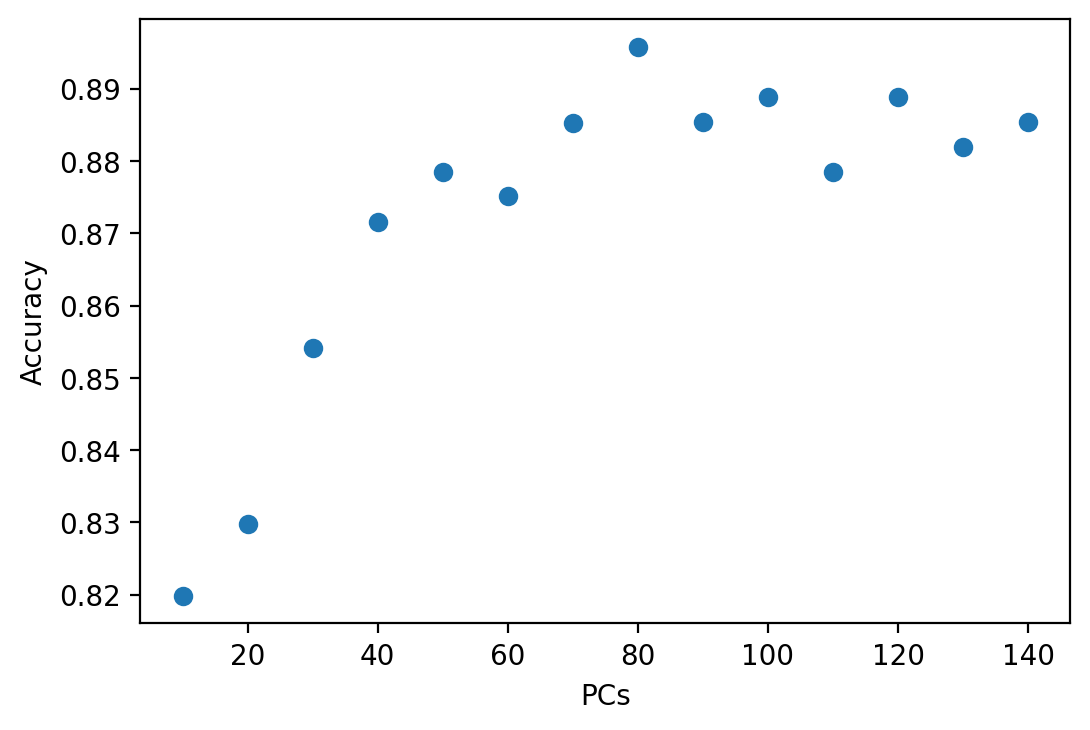

In [93]:
plt.figure(dpi=200)
plt.scatter(pcs_list, pcs_acc_res)
plt.xlabel("PCs")
plt.ylabel("Accuracy")
# plt.plot([0, 1], [0, 1], "--r")
# plt.axes().set_aspect(aspect='equal')
plt.show()
# plt.savefig('/Users/harelhe/downloads/pcs_plot.tiff')

In [207]:
df = pd.read_csv("/Users/harelhe/downloads/MBM_NIH_Primary.csv")
df['Position in cell'] = df['Position in cell'].replace(['EDG'], ['MEM'])

# df['label'] = df['main_type']
# dfmem = df[df['Position in cell']=='MEM']
# dfcyt = df[df['Position in cell']=='CYT']
# dfcen = df[df['Position in cell']=='C00']
# df = dfcen
# df['label'] = df['label'].replace(['MBM', 'NIH', 'PRI'], [0, 1, 2])

df['label'] = df['main_type']
df['label'] = df['label'].replace(['MBM', 'NIH', 'PRI'], [0, 1, 2])
df = df.groupby(['main_type','Groups']).mean()
df = df.drop(['main_group_by_day'], axis=1)

anti = ['label']
random_state = 0
grid_param = 5
n_splits = 10
pcs_acc_res = []
tr_acc_scores = []
for i_anti in anti:
    print(i_anti)
    df = df[df[i_anti].notna()]
#     wl_start = "1801.264"
#     wl_end = "898.703"
    wl_start = "600"
    wl_end = "1800"
    rawX = df.loc[:, wl_start:wl_end].values
    rawX_der = sgf(rawX, window_length=13, polyorder=3, deriv=2, mode="nearest")
    rawY = df[i_anti].values
#     x = rawX_der
    x = rawX
#     x = pooling_avg(x, 2)
    y = rawY
    kfold_data = []
    kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    kf.get_n_splits(x, y)

    for train_index, test_index in kf.split(x, y):  # pool.map
        # kfold_indices.append([train_index, test_index])
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
#         x_train, scale_ = standard_scale(x_train)
#         x_train, pca_ = pca_transformation(x_train, 30)
    # SelectKBest mutual_info_classif, f_classif
#         kbest = SelectKBest(score_func=f_classif, k=150)
#         kbest.fit(x_train, y_train)
#         x_train = kbest.transform(x_train)
#         x_test = scale_.transform(x_test)
#         x_test = pca_.transform(x_test)
        clf = svm.SVC(kernel='linear', C=1000, decision_function_shape='ovr', random_state=0, class_weight='balanced', probability=True)
        kfold_data.append([x_train, x_test, y_train, y_test, clf])

    p = Pool(processes=10)
    start = time.time()
    res = p.map(cv_test_avg, kfold_data)
    labels = []
    probs = []
    acc_scores = []
    p.close()
    p.join()


label

In [208]:
# y = label_binarize(y, classes=[0,1,2])
labels = []
probs = np.empty_like([[0,0,0]])
for i_res in res:
    labels.extend(i_res[1])
    probs = np.concatenate([probs,i_res[0]])
labels = label_binarize(labels, classes=[0,1,2])
probs = np.delete(probs, 0, axis=0)
labels = np.array(labels)

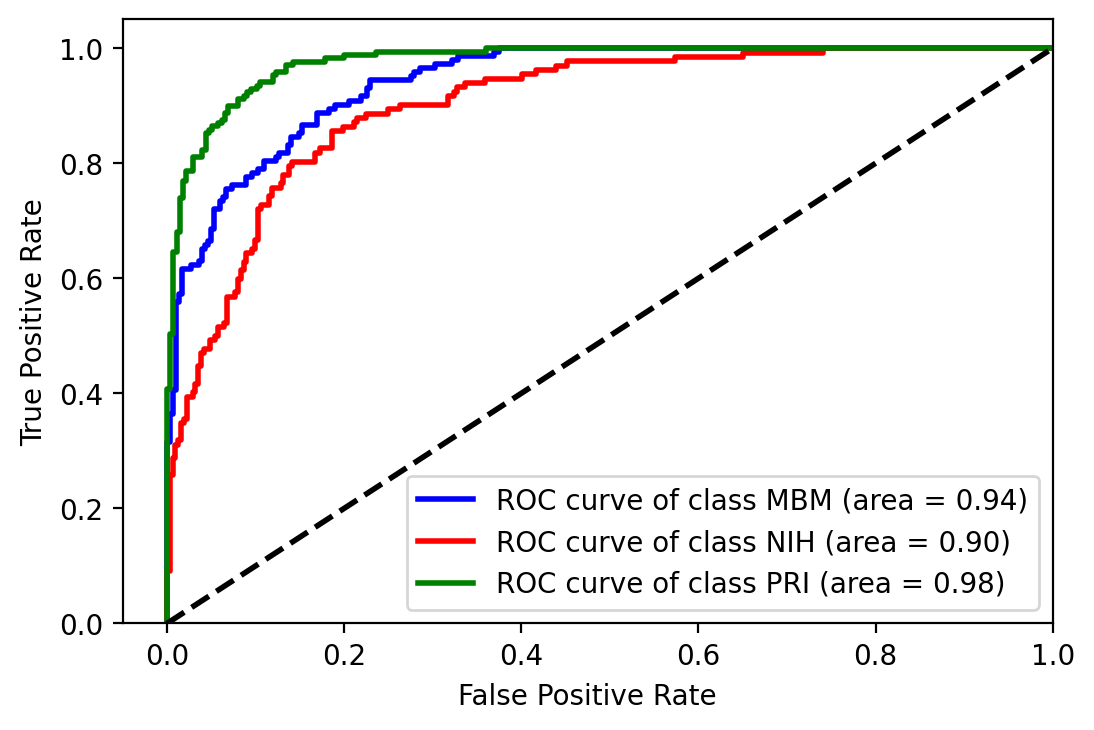

In [209]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
plt.figure(dpi=200)
class_names = ['MBM', 'NIH', 'PRI']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('avera')
plt.legend(loc="lower right")
# plt.show()
plt.savefig('/Users/harelhe/downloads/roc_avg_RF.tiff')

In [96]:
clf.decision_function_shape

'ovr'